# Molecule Plot Examples

by [Matt Geballe](https://twitter.com/mattgeballe/)

----

Many times in computational chemistry we plot molecules as individual data points, often in a scatter plot. Having images of the molecule (2D depictions of the molecular graph) as tooltips for the points on the plot is a very useful pattern so questions about interesting points can be pursued. 

This notebook will cover attempts to construct these plots using different python plotting libraries.

**Loading Data**

We'll use OENotebook to read some molecules into a [pandas](http://pandas.pydata.org/) DataFrame, then calculate some properties using the [OEChem](http://docs.eyesopen.com/toolkits/python/oechemtk/index.html) and [MolProp](http://docs.eyesopen.com/toolkits/python/molproptk/index.html) tooltkits.

In [1]:
from __future__ import print_function

# import OE tools and data
import oenotebook as oenb
# oenb.capture_errors()

import warnings
warnings.filterwarnings("ignore")

from openeye.oechem import OECalculateMolecularWeight
from openeye.oemolprop import OEGetXLogP, OEGet2dPSA
%matplotlib inline

# oenb.style()

In [2]:
# Read molecules into a Pandas Dataframe
df = oenb.read_file_to_dataframe("./eMol_ran50.ism", title_col="Title")

# Calculate some Properties
df["MW"] = df.Molecule.apply(OECalculateMolecularWeight)
df["XlogP"] = df.Molecule.apply(OEGetXLogP)
# df["2D_PSA"] = df.Molecule.apply(OEGet2dPSA)

# Check to make sure data looks right
df.describe()

MW      XlogP
count   50.000000  50.000000
mean   364.959820   3.117720
std     82.409009   1.444342
min    155.220760  -0.931000
25%    316.245407   2.189250
50%    360.088080   3.230000
75%    411.317835   3.989500
max    590.795900   6.190000

<!-- fold -->

## Matplotlib and mpld3

[Matplotlib](http://matplotlib.org/) is one of the oldest, most widely-used, and fully-featured python plotting libraries. We will use it first to make a basic scatter plot, then use [mpld3](https://mpld3.github.io/) to combine the matplotlib figure with [D3js](http://d3js.org/) and generate an interactive visualization.

In [3]:
# import matplotlib and setup style
%matplotlib inline

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

**Simple scatter plot to compare Molecular Weight and XlogP**

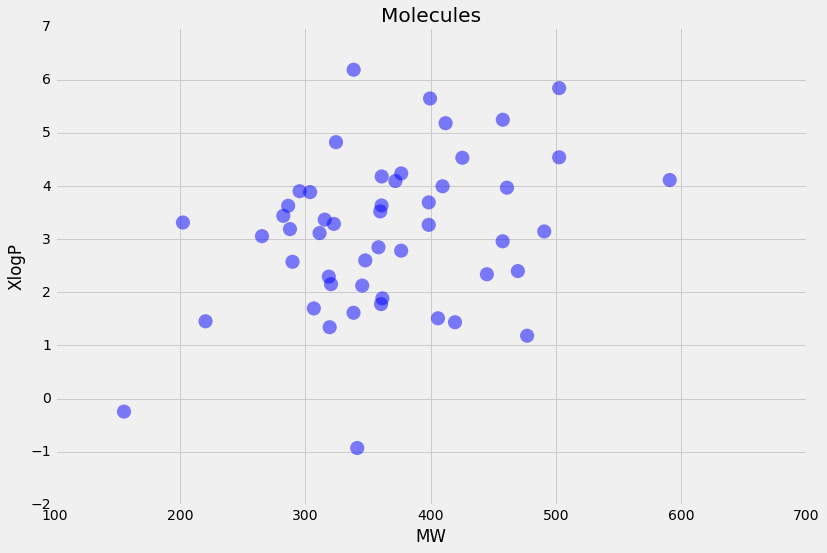

In [4]:
# Define figure
plt.figure(figsize=(12,8))

# Make the scatterplot
plt.scatter(df.MW,df.XlogP,s=200,alpha=0.5,edgecolors='none',label="Molecules")

# Add axis labels and title
plt.xlabel("MW")
plt.ylabel("XlogP")
plt.title("Molecules");

# plt.savefig("my_plot.png")

**Add 2D depiction toolkits using MPLD3**

In [5]:
import mpld3

In [6]:
# Create list of image URIs
molImgs = list(df.Molecule.apply(lambda x: oenb.draw_mol_to_img_tag(x,300,200)))



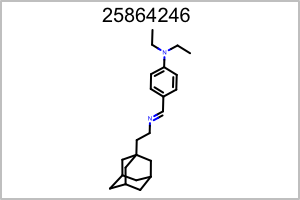

In [7]:
# Confirm our image creation worked
from IPython.display import HTML
HTML(molImgs[0])

In [8]:
df.head()

Molecule     Title          MW  \
0  <oechem.OEMol; proxy of <Swig Object of type '...  25864246  338.529460   
1  <oechem.OEMol; proxy of <Swig Object of type '...  25167497  425.310520   
2  <oechem.OEMol; proxy of <Swig Object of type '...  24665960  289.716980   
3  <oechem.OEMol; proxy of <Swig Object of type '...   2251284  376.519520   
4  <oechem.OEMol; proxy of <Swig Object of type '...   5632287  419.421826   

      XlogP  
0  6.190000  
1  4.533000  
2  2.575000  
3  4.237999  
4  1.437000


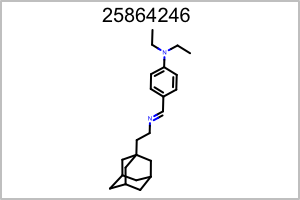
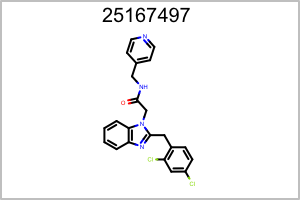
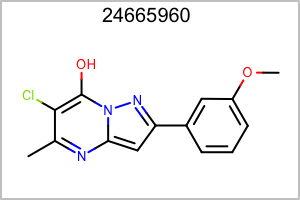
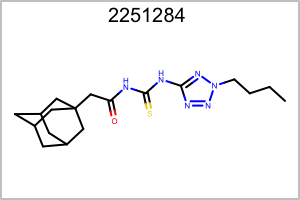
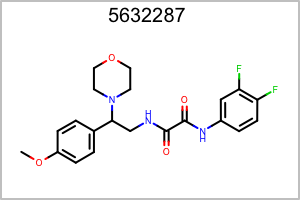
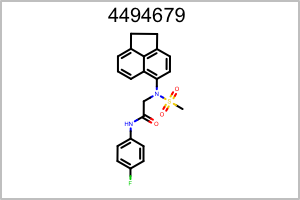
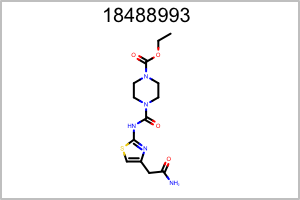
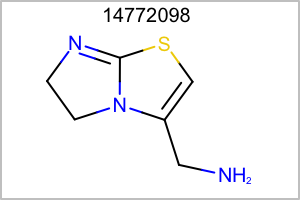
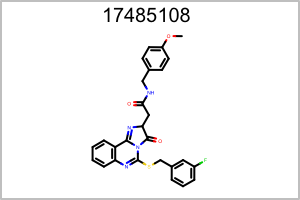
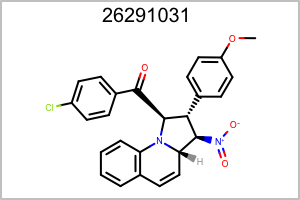
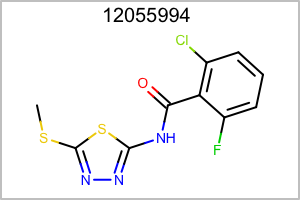
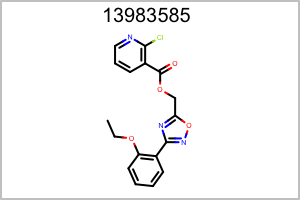
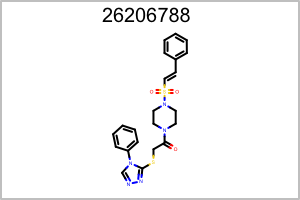
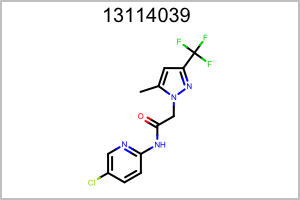
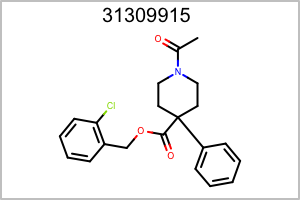
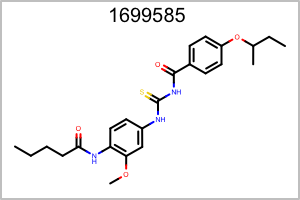
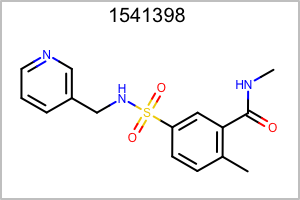
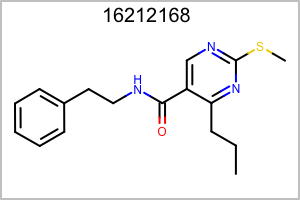
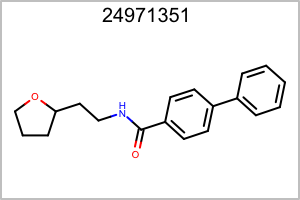
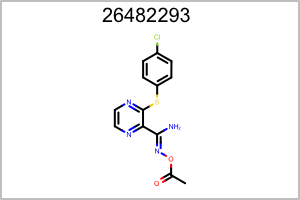
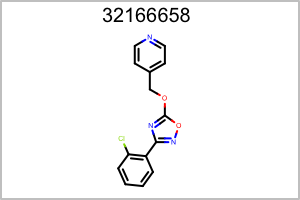
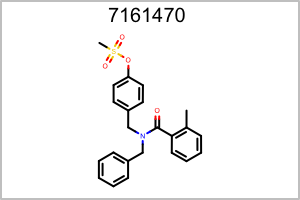
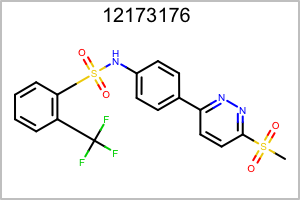
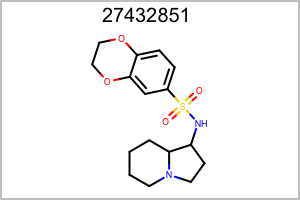
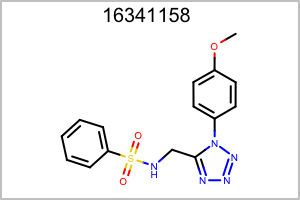
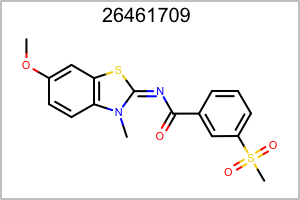
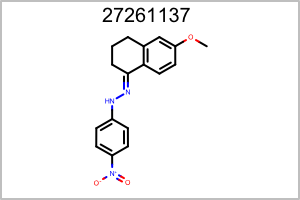
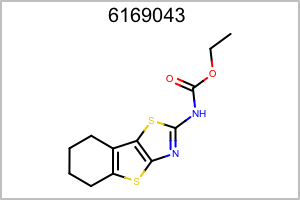
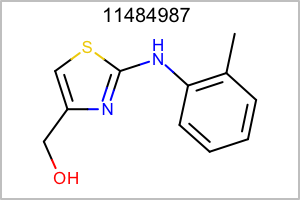
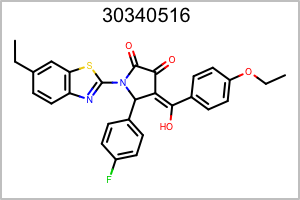
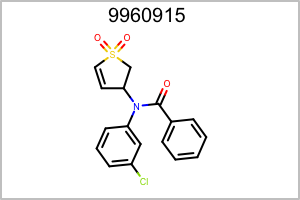
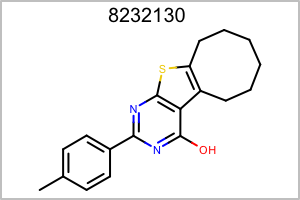
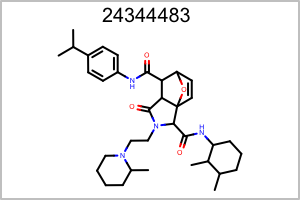
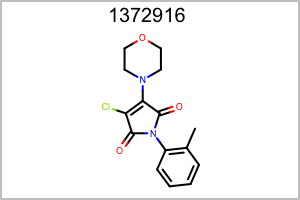
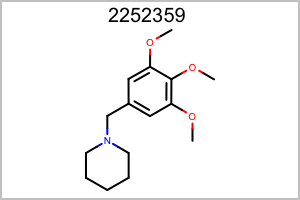
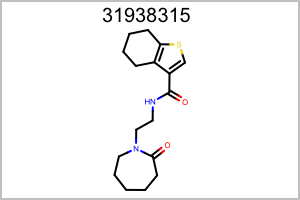
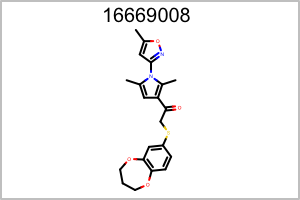
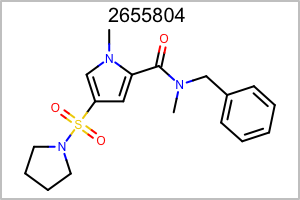
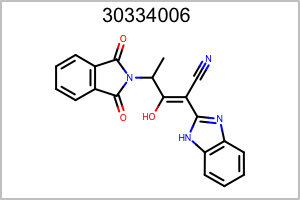
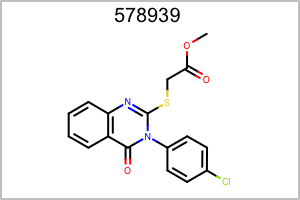
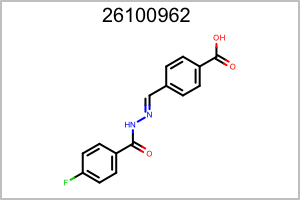
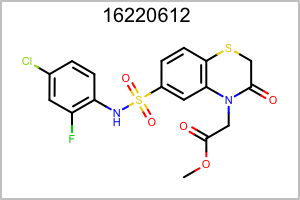
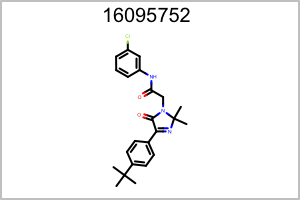
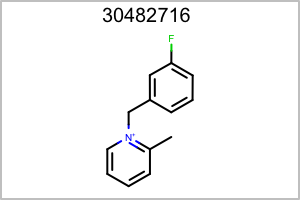
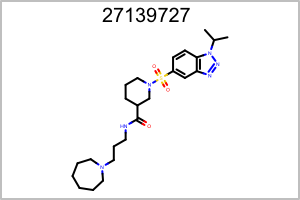
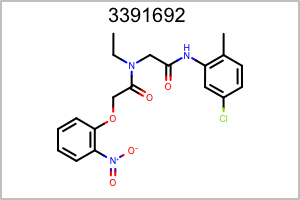
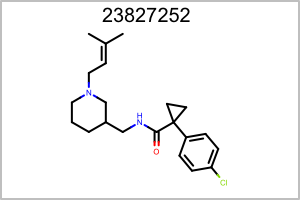
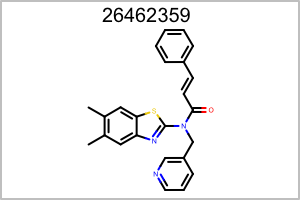
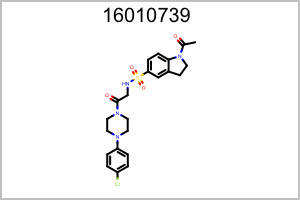
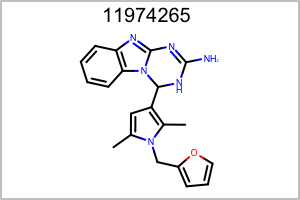
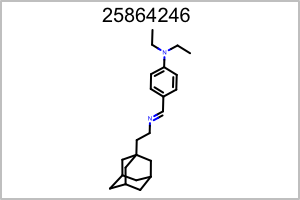
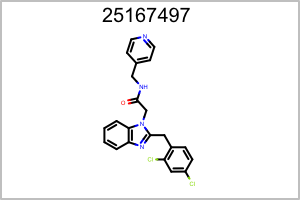
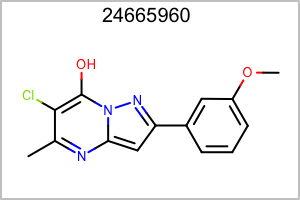
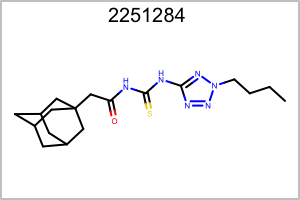
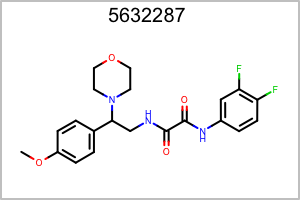
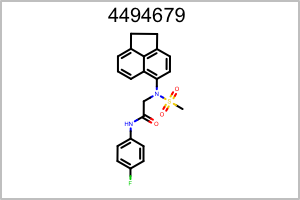
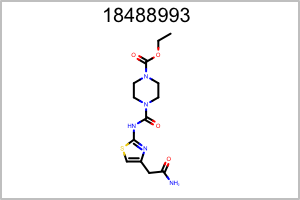
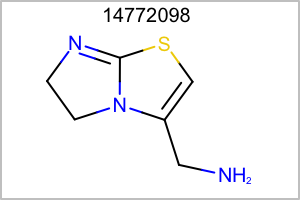
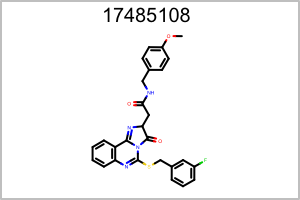
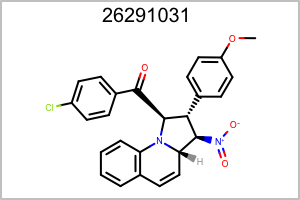
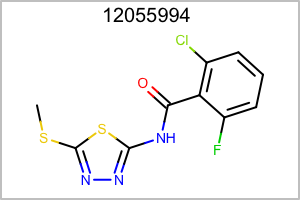
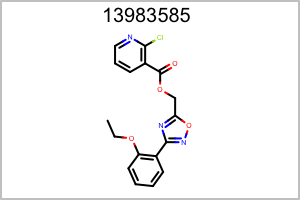
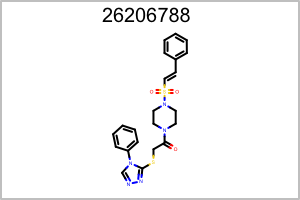
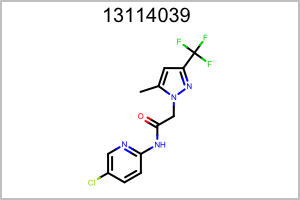
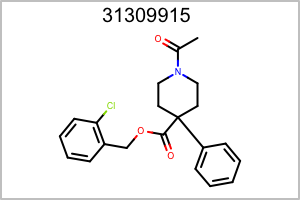
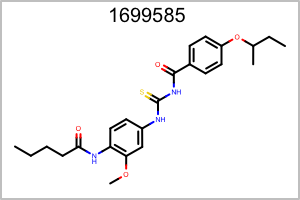
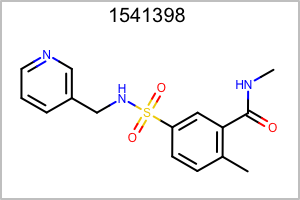
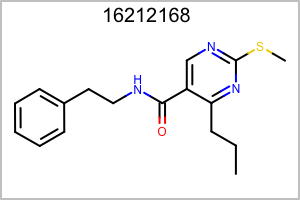
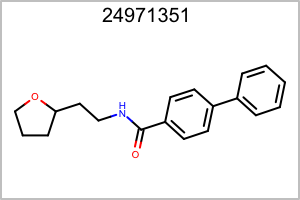
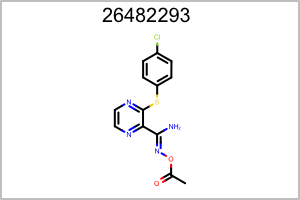
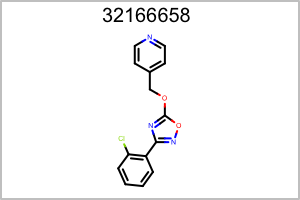
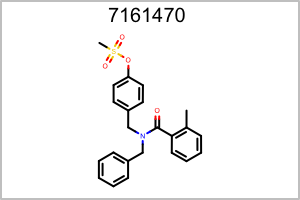
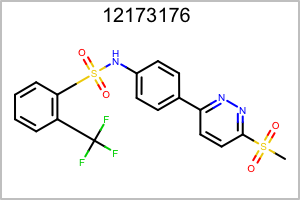
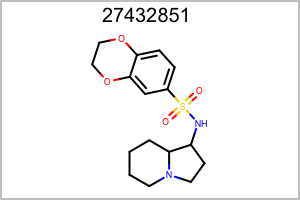
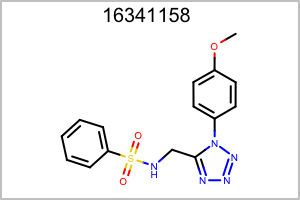
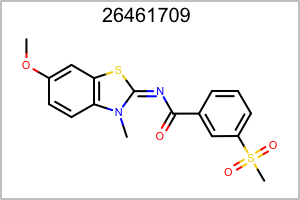
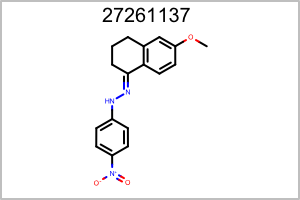
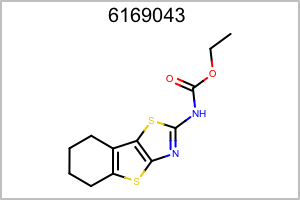
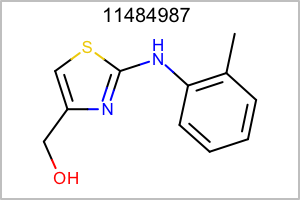
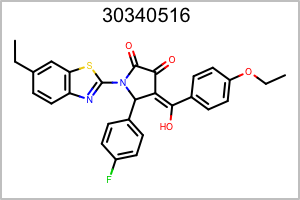
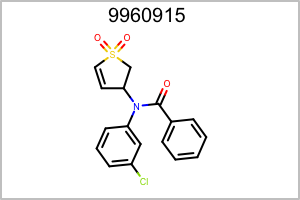
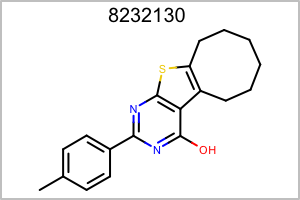
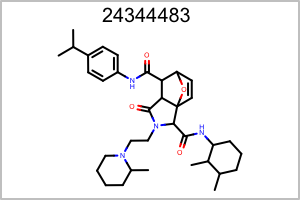
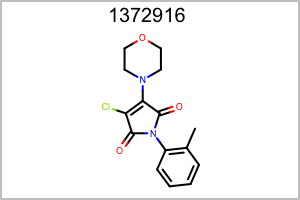
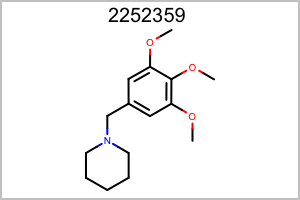
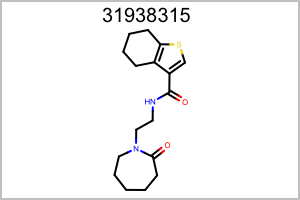
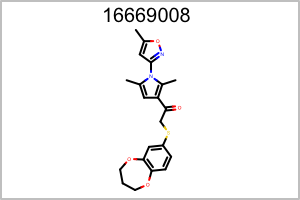
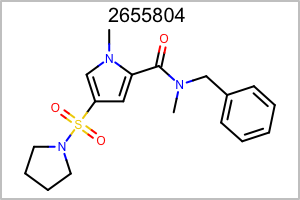
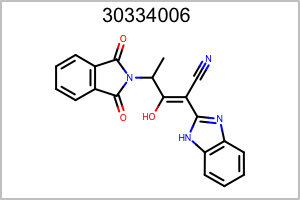
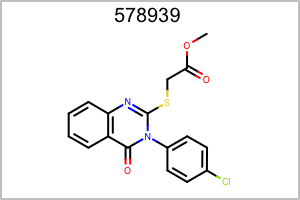
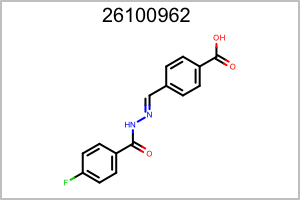
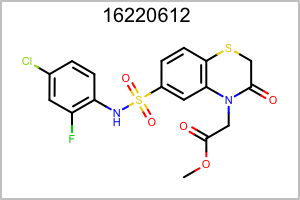
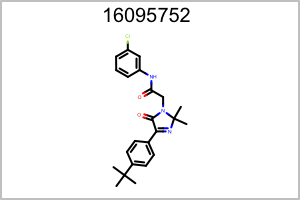
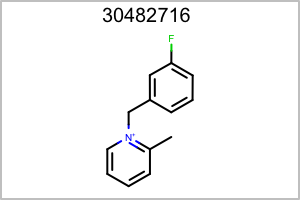
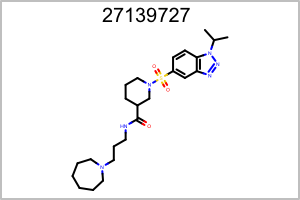
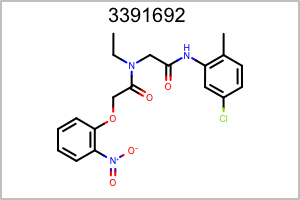
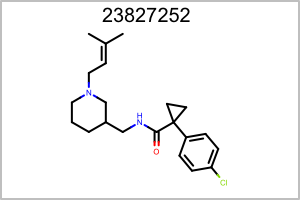
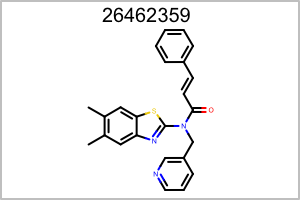
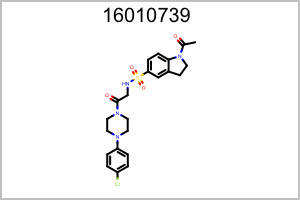
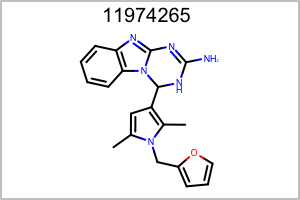
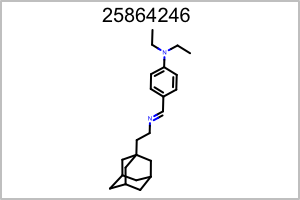
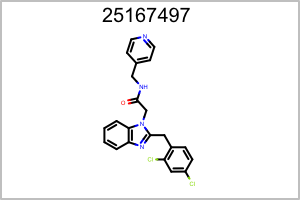
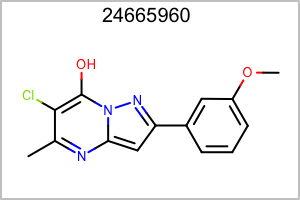
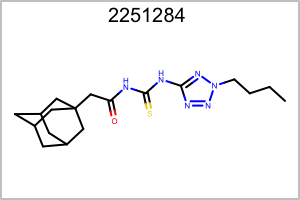
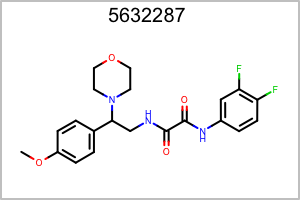
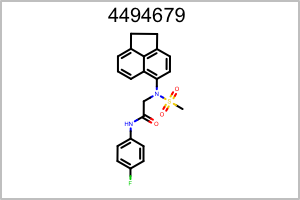
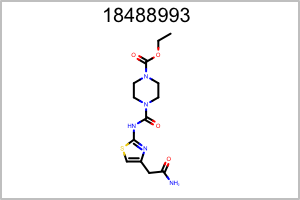
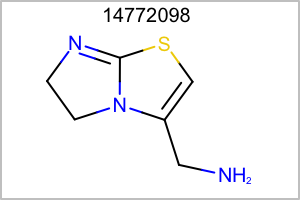
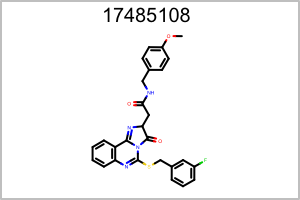
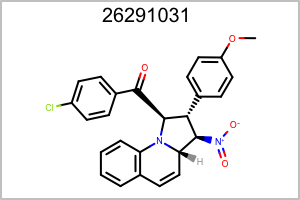
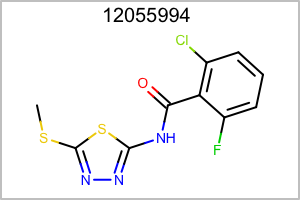
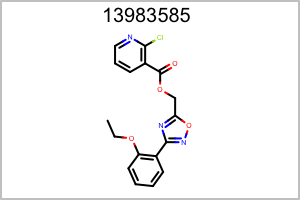
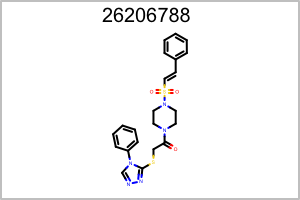
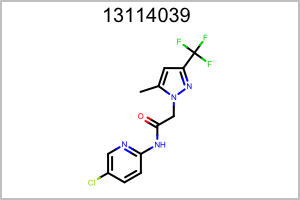
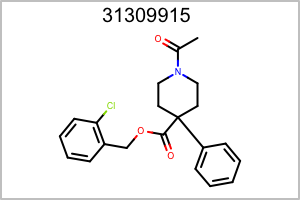
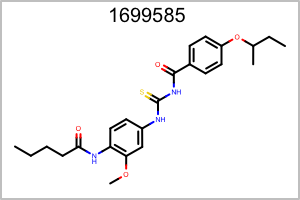
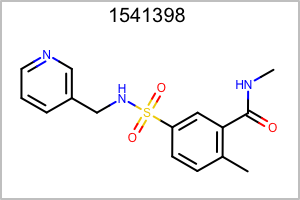
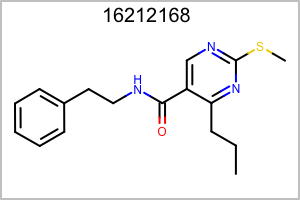
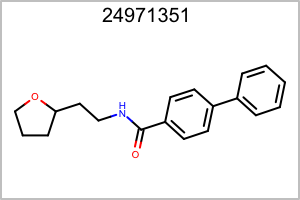
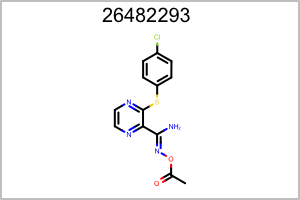
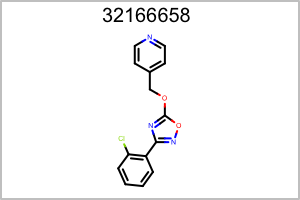
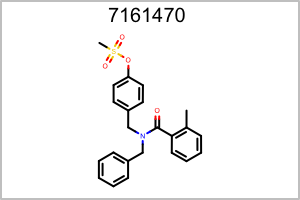
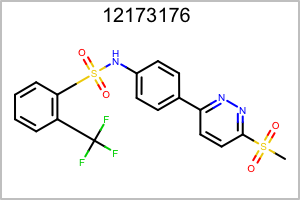
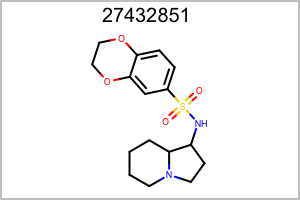
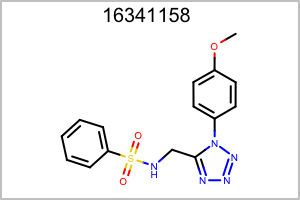
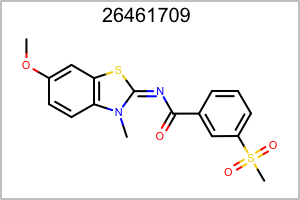
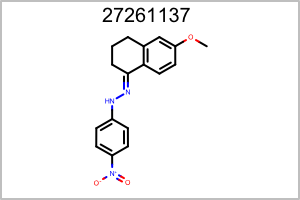
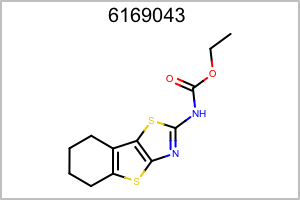
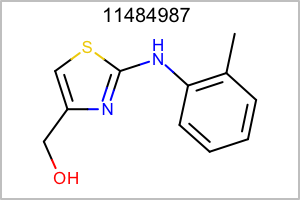
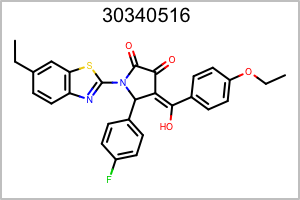
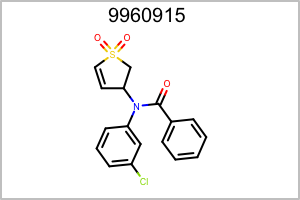
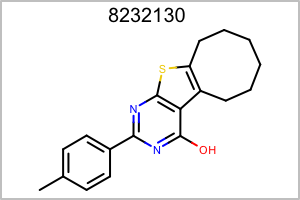
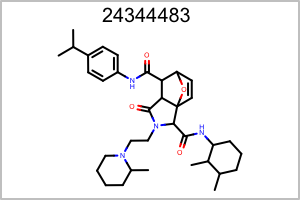
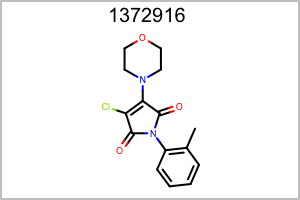
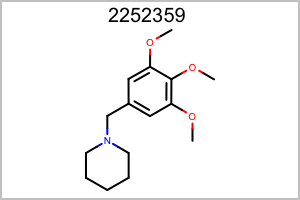
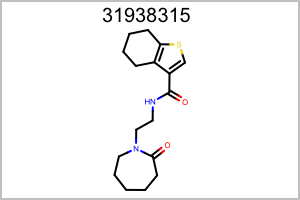
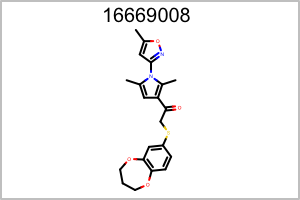
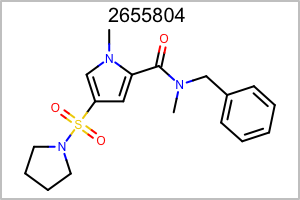
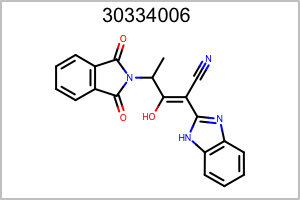
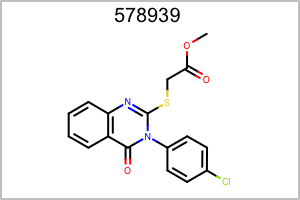
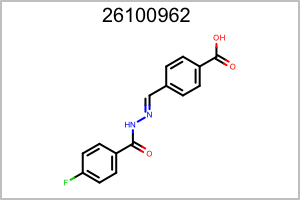
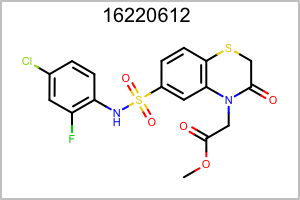
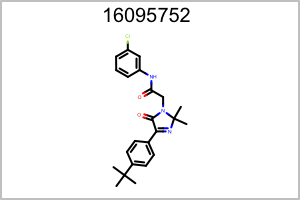
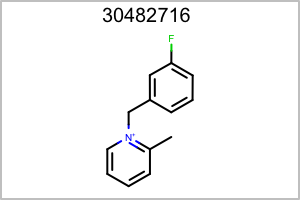
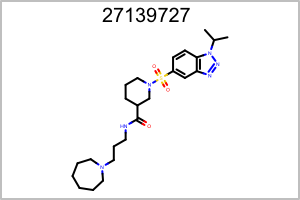
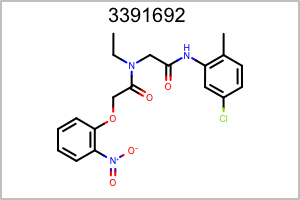
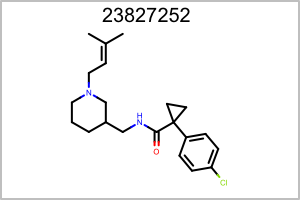
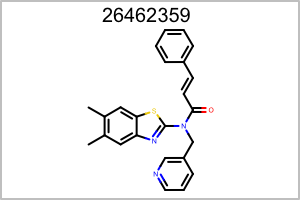
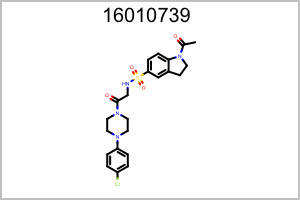
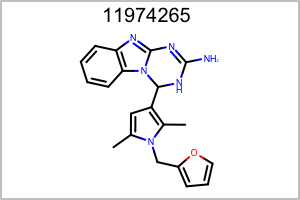

In [9]:
import pandas as pd

# Define figure and axes, hold on to object since they're needed by mpld3
fig, ax = plt.subplots(figsize=(12,8))

# Make scatterplot and label axes, title
sc = ax.scatter(df.MW,df.XlogP,s=200,alpha=0.5,edgecolors='none')
plt.xlabel("MW")
plt.ylabel("XlogP")
plt.title("Molecules")

# Create the mpld3 HTML tooltip plugin
tooltip = mpld3.plugins.PointHTMLTooltip(sc, molImgs)
# tooltip = mpld3.plugins.PointHTMLTooltip(sc, list(df.apply(lambda x: pd.DataFrame({x["Molecule"].GetTitle():[x["MW"],x["XlogP"]]},index=["MW","XlogP"]).to_html(escape=False))))


# Connect the plugin to the matplotlib figure
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

# Uncomment to save figure to html file
#mpld3.save_html(fig,"mpld3_fig.html")

This functionality is also built in to OENotebook.


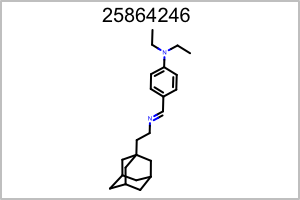
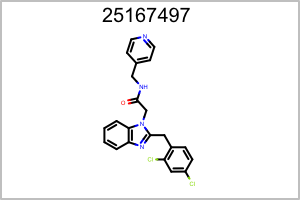
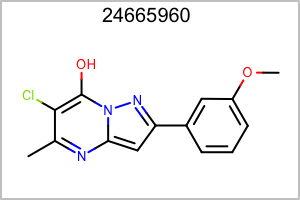
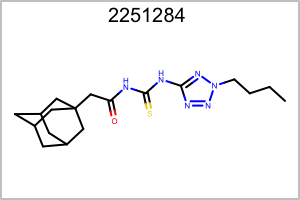
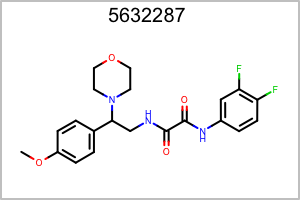
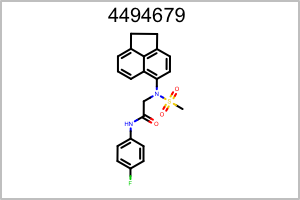
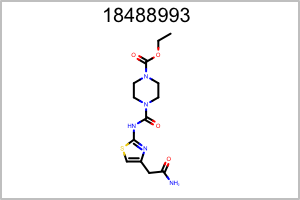
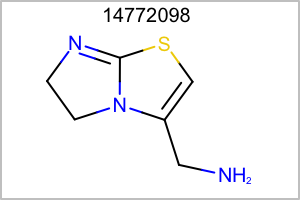
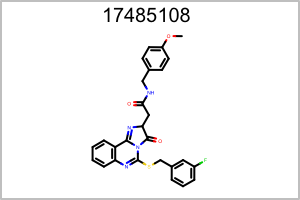
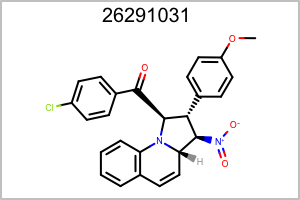
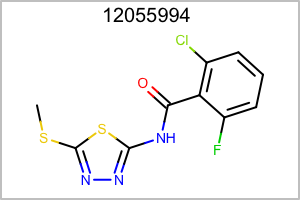
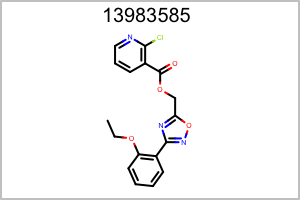
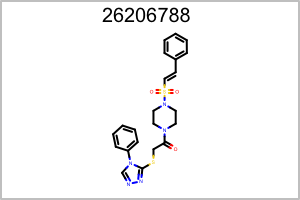
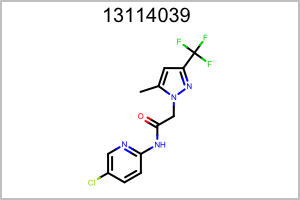
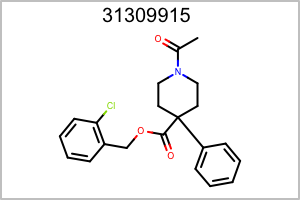
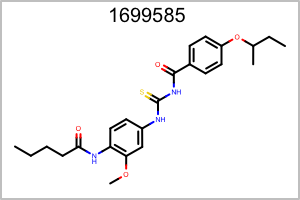
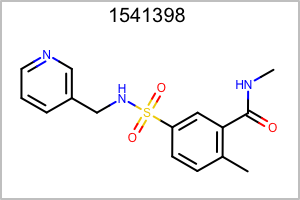
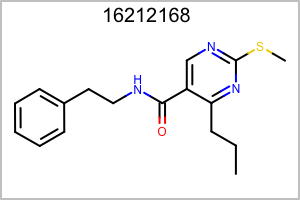
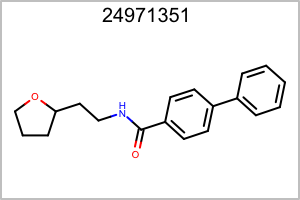
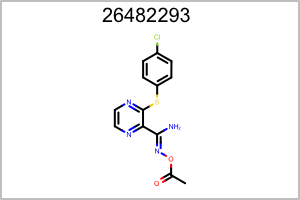
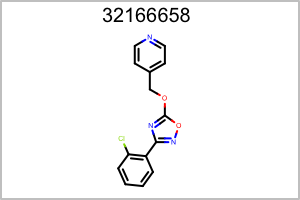
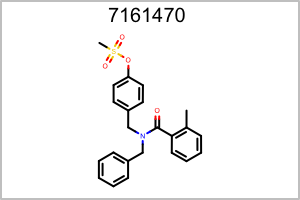
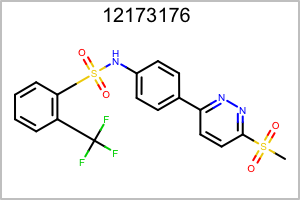
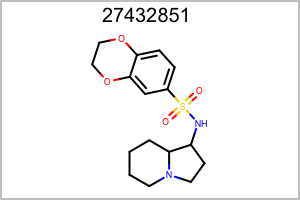
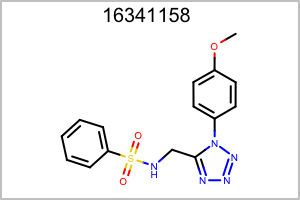
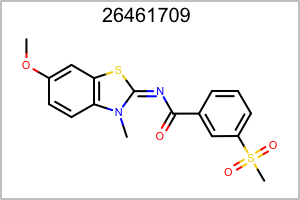
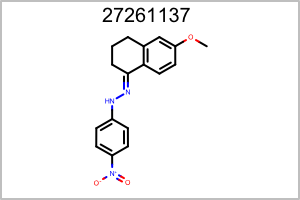
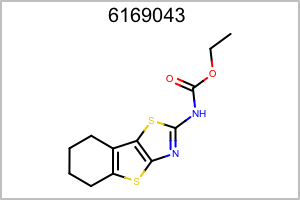
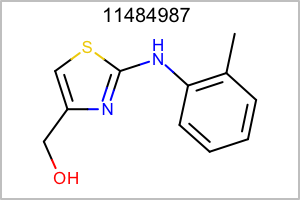
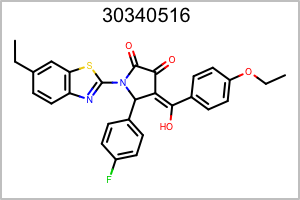
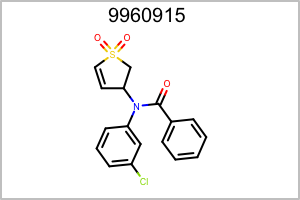
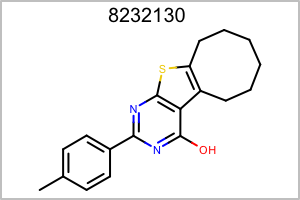
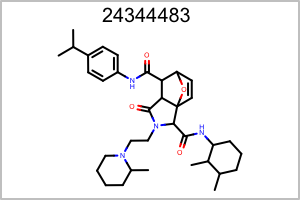
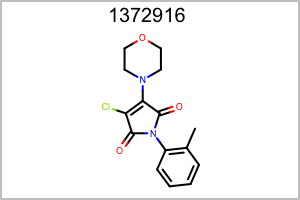
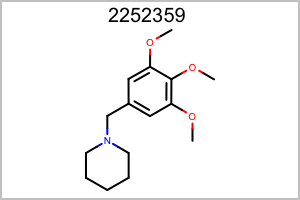
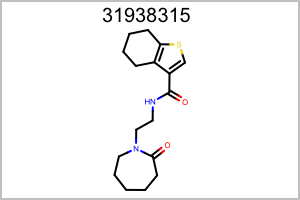
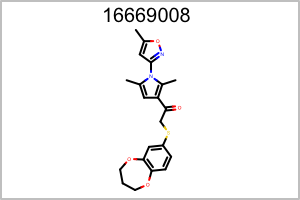
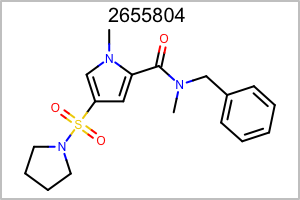
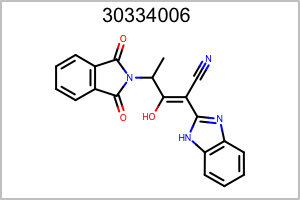
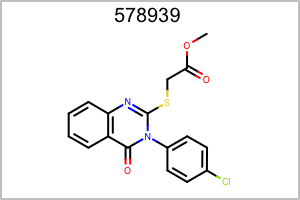
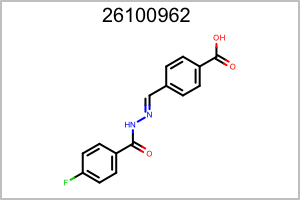
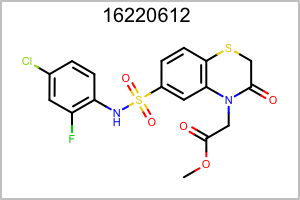
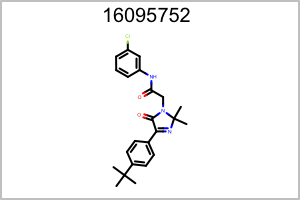
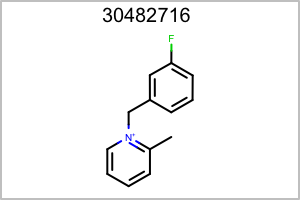
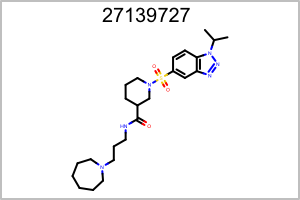
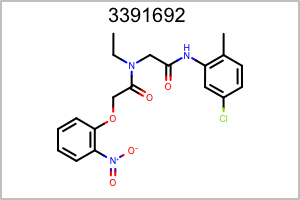
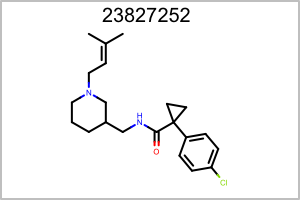
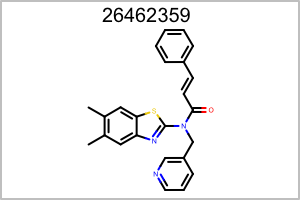
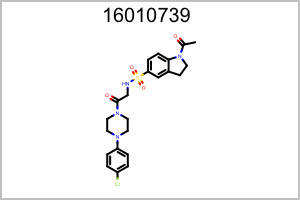
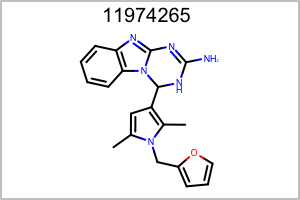
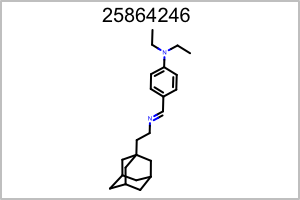
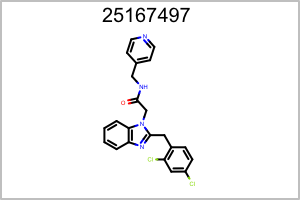
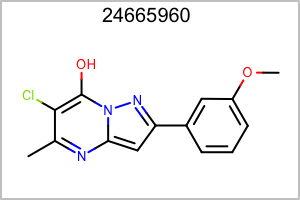
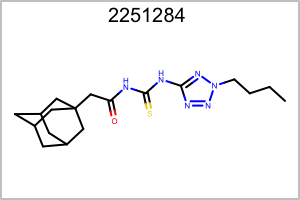
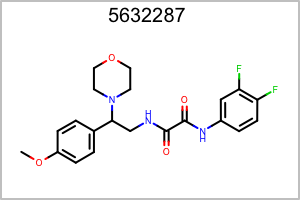
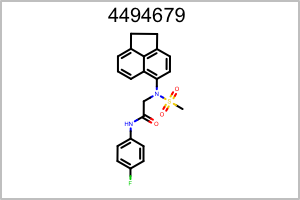
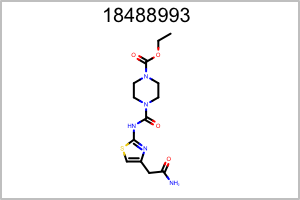
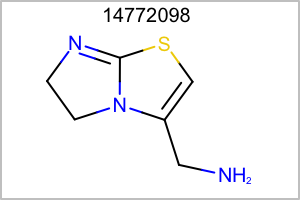
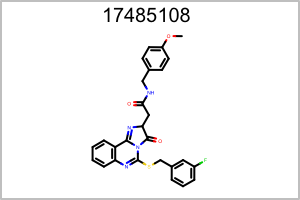
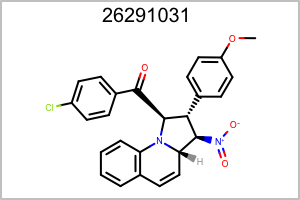
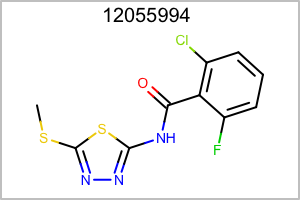
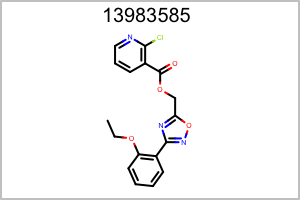
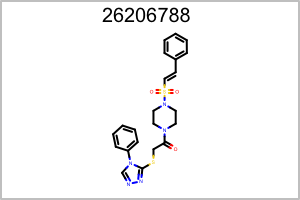
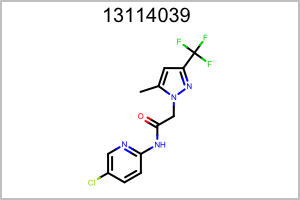
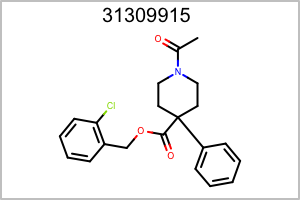
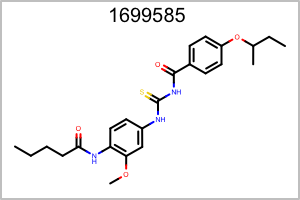
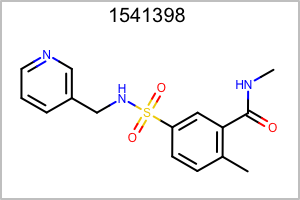
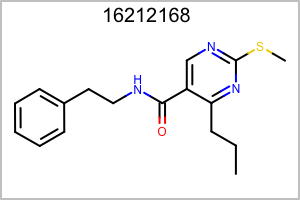
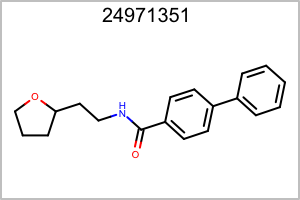
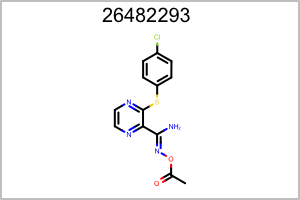
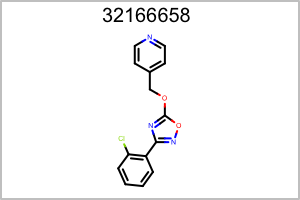
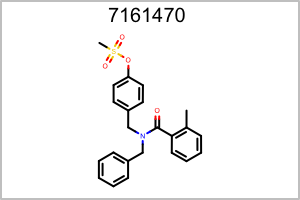
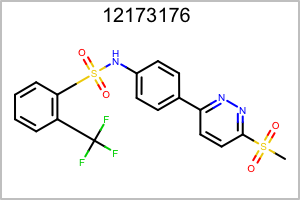
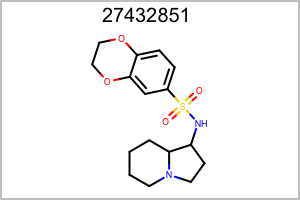
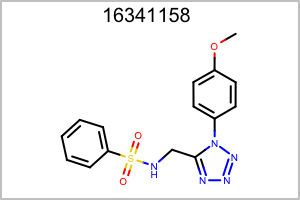
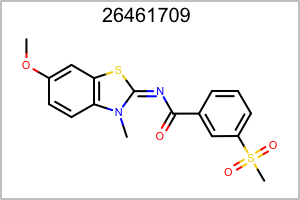
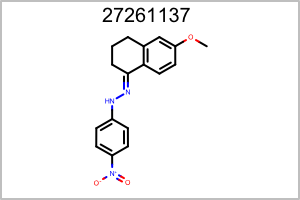
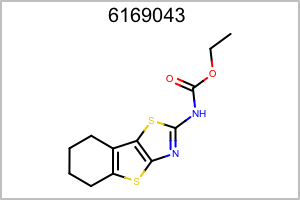
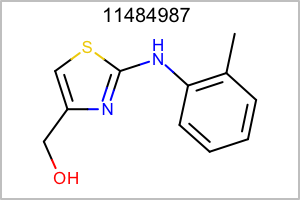
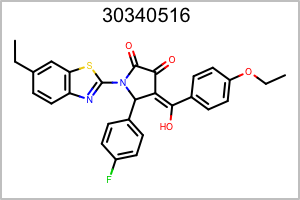
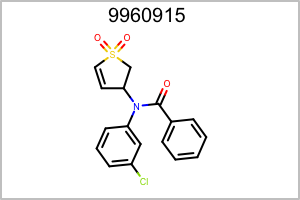
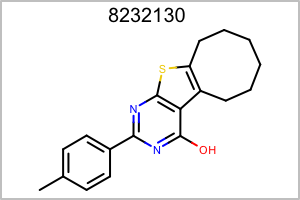
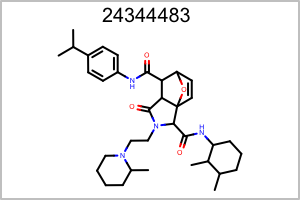
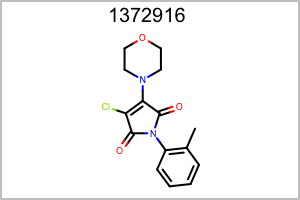
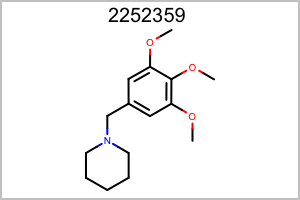
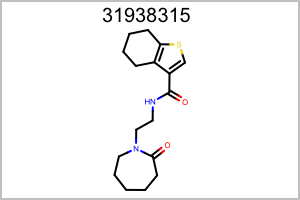
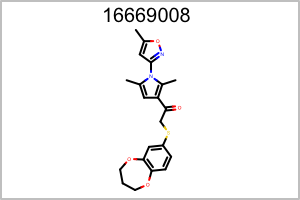
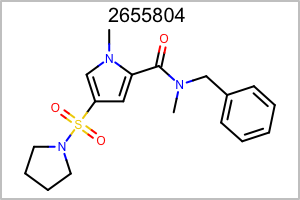
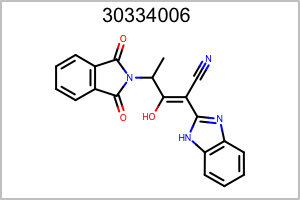
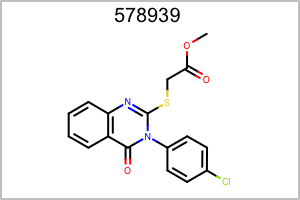
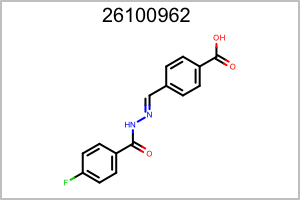
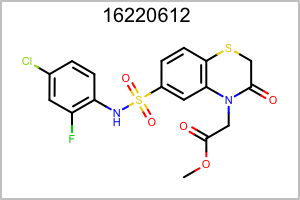
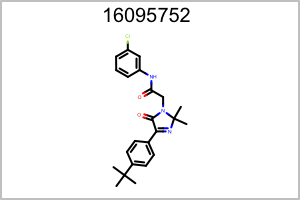
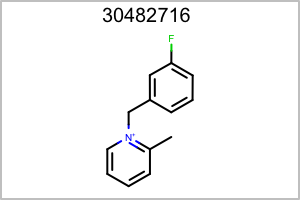
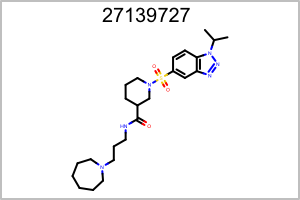
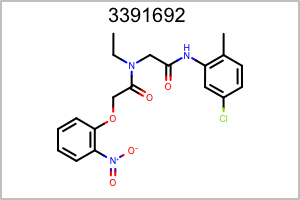
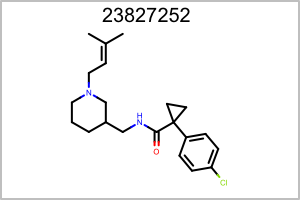
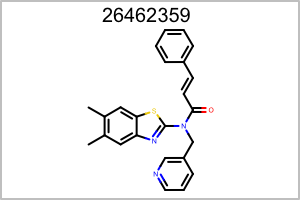
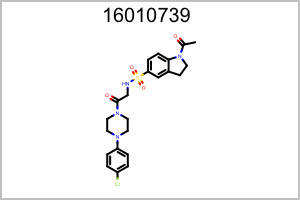
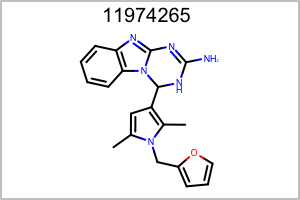
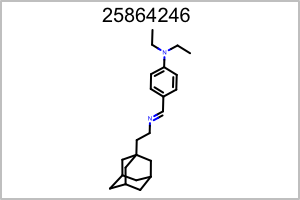
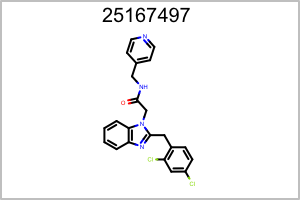
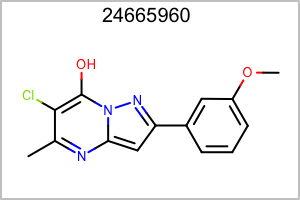
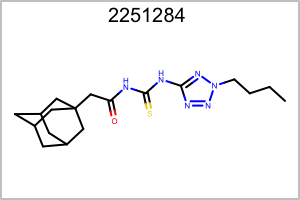
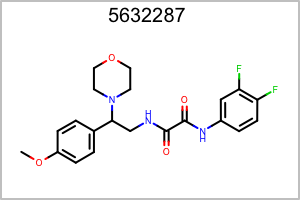
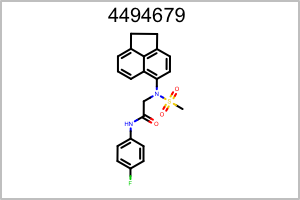
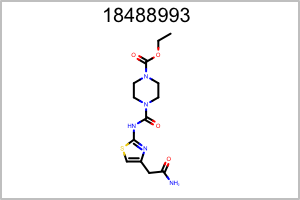
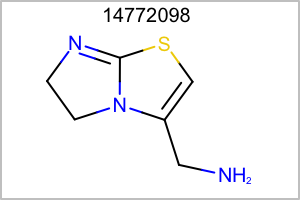
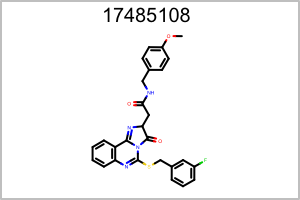
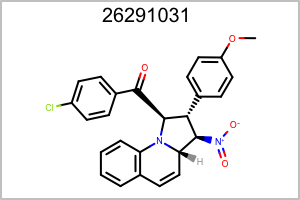
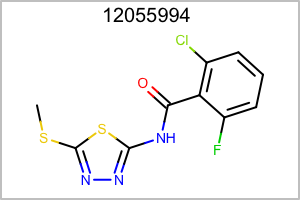
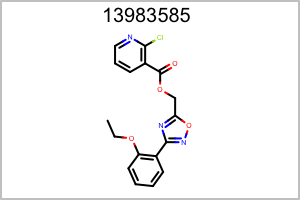
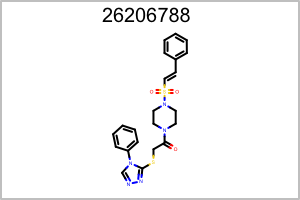
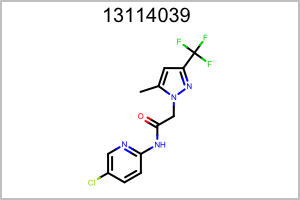
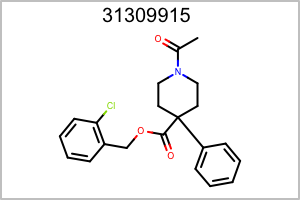
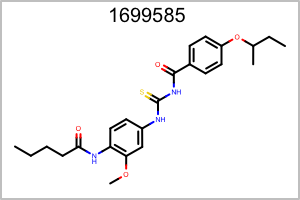
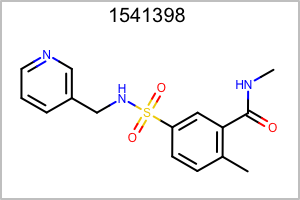
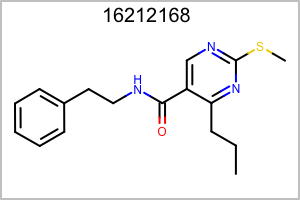
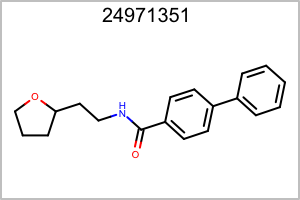
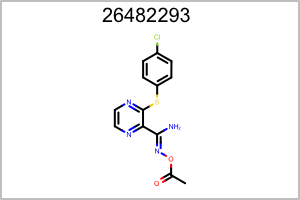
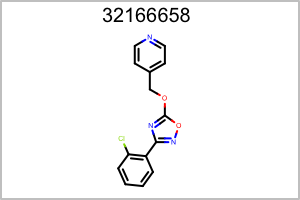
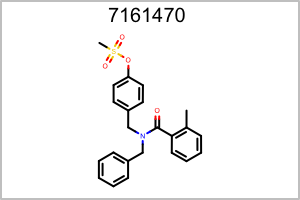
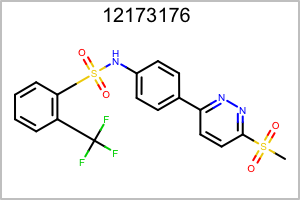
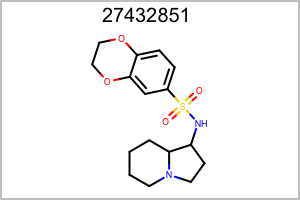
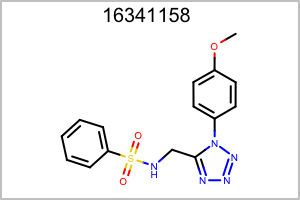
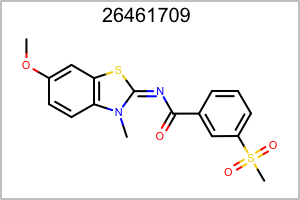
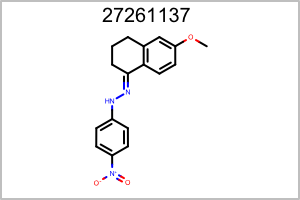
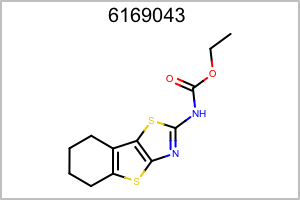
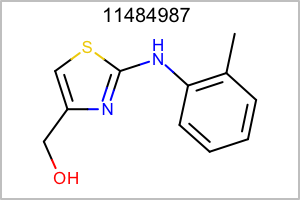
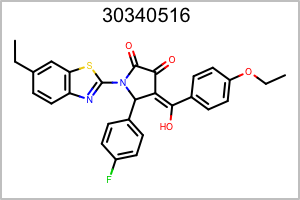
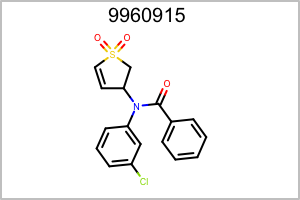
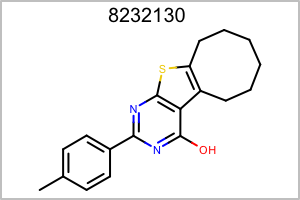
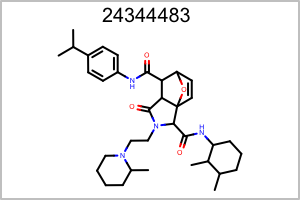
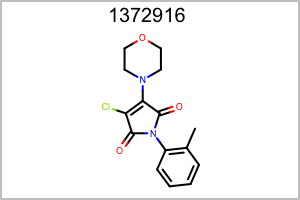
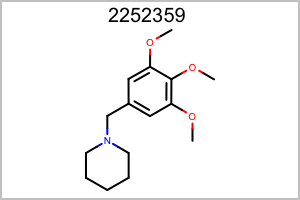
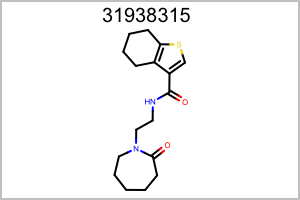
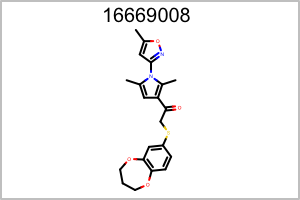
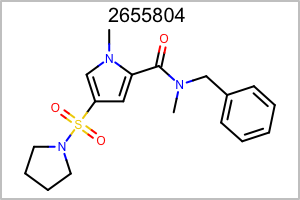
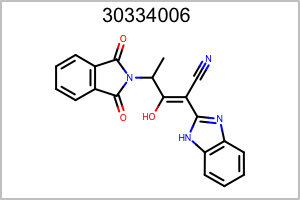
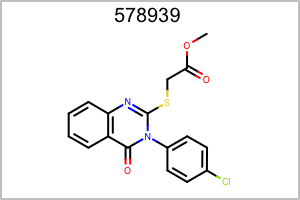
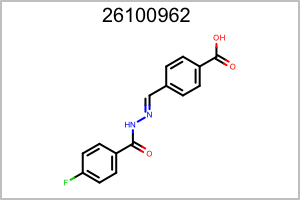
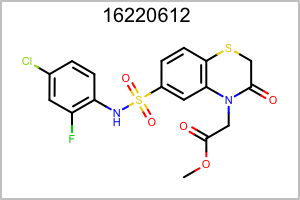
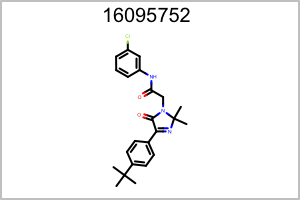
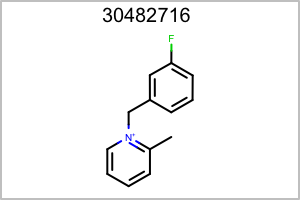
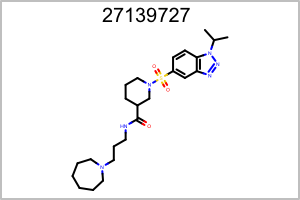
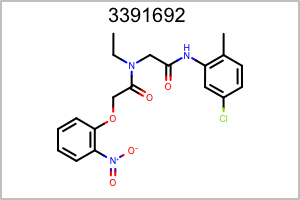
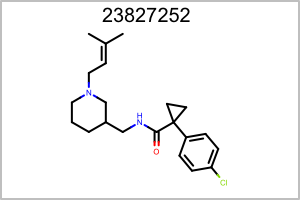
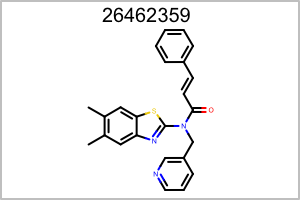
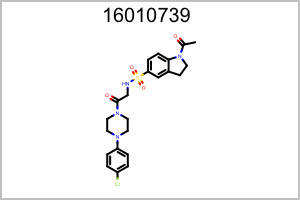
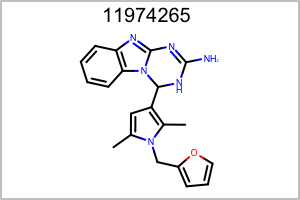

In [10]:
f,a = oenb.scatter_mpl(df,"MW","XlogP")

In [11]:
f,a = oenb.scatter_mpl(df,"MW","XlogP",show_2D=False)

## Bokeh

[Bokeh](http://bokeh.pydata.org/) is a plotting library designed from the beginning for interactive plots in modern browsers. It contains all the javascript components necessary to provide interactive tooltips.

In [13]:
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook


from bokeh.models import HoverTool, Callback
from collections import OrderedDict

# Configure default tools for plots
TOOLS = 'box_zoom,box_select,resize,reset,save'

# Configure for output in the notebook
output_notebook()

Loading BokehJS ...

**Simple scatter plot with data tooltips**

In [14]:
# Store data in a bokeh object data object
source = ColumnDataSource(df.drop("Molecule",axis=1))

p = figure(title="Molecules", tools = TOOLS)
p.xaxis.axis_label = 'MW'
p.yaxis.axis_label = 'XLogP'

# Make scatterplot
p.circle("MW", "XlogP", fill_alpha=0.2, size=10, source=source)


# Configure hover tooltip with simple information about each point
hover = HoverTool()
hover.tooltips = OrderedDict([
    ('Title', '@Title'),
    ('MW', '@MW'),
    ('XlogP', '@XlogP'),
])
p.add_tools(hover)

show(p)

**Now to add the images as tooltips**


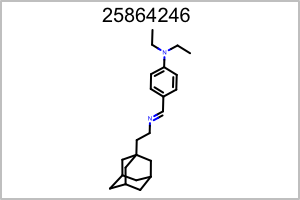
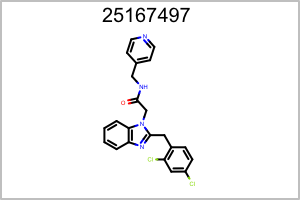
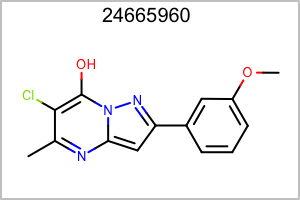
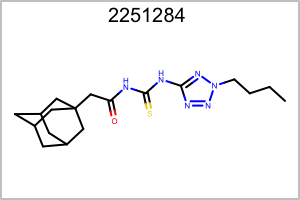
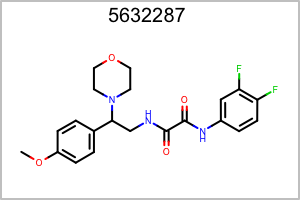
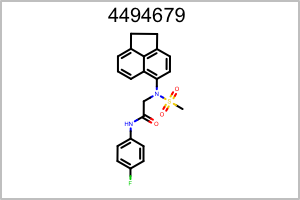
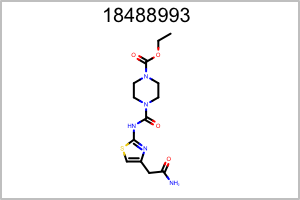
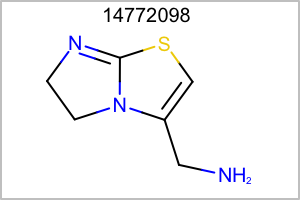
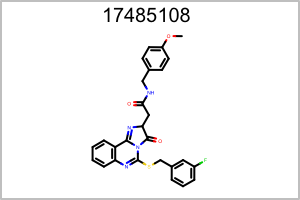
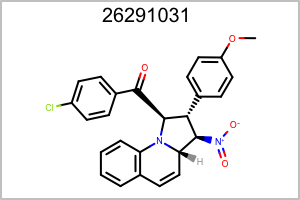
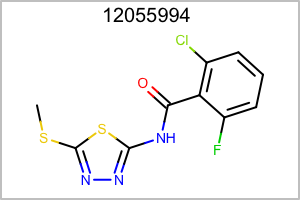
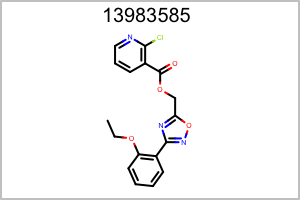
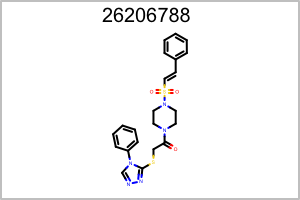
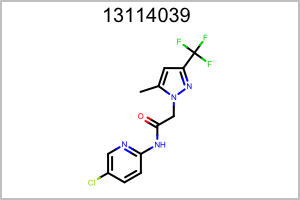
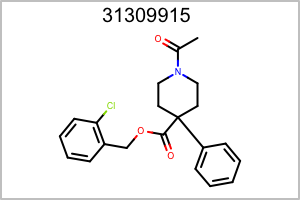
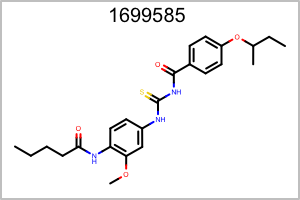
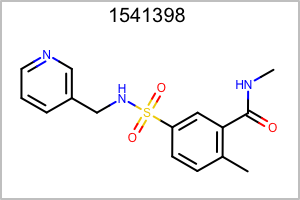
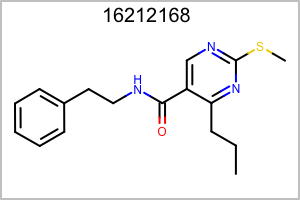
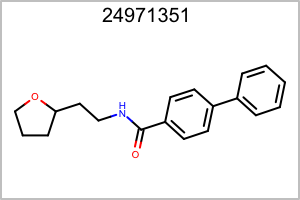
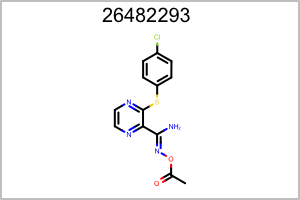
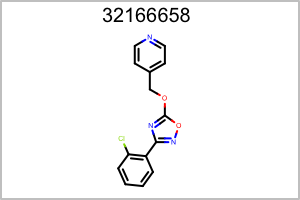
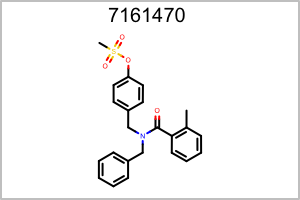
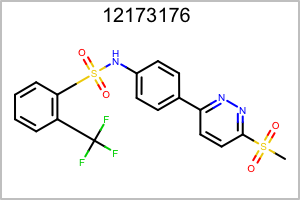
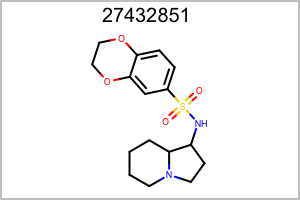
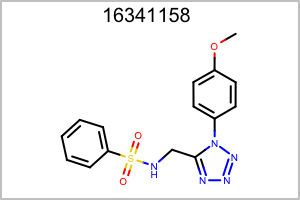
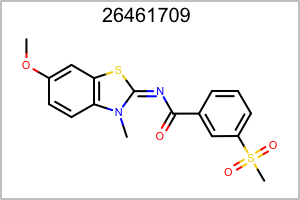
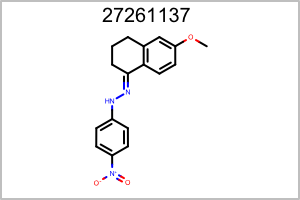
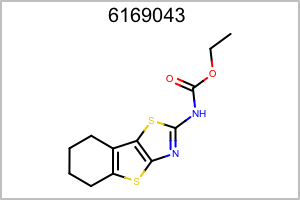
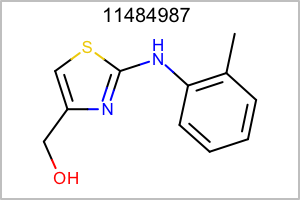
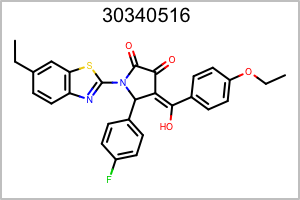
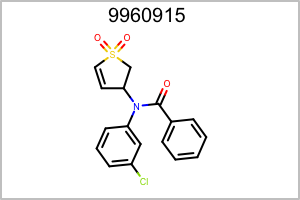
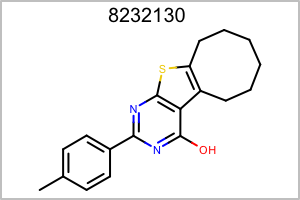
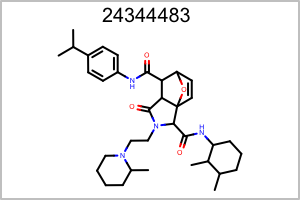
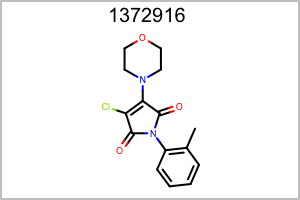
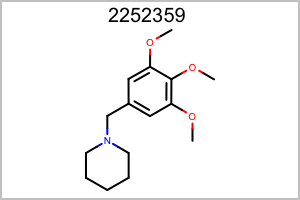
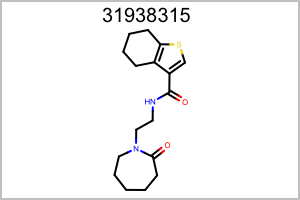
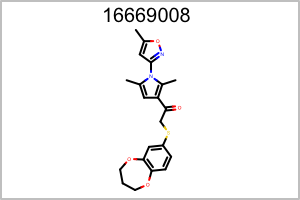
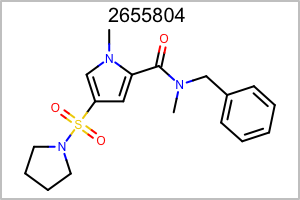
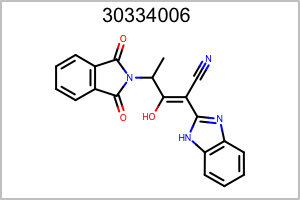
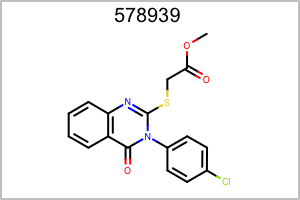
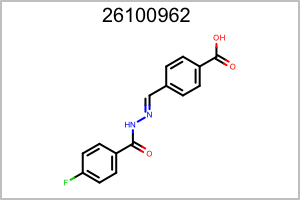
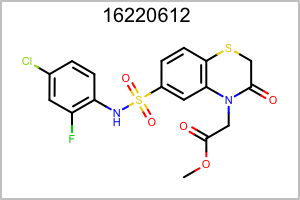
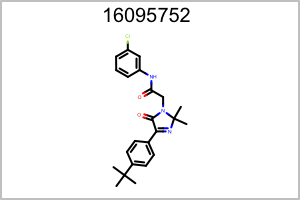
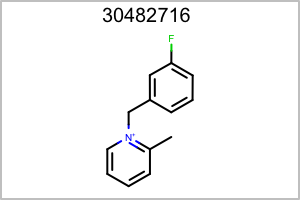
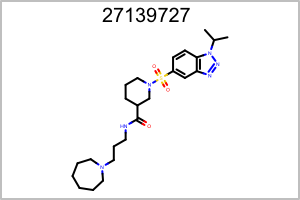
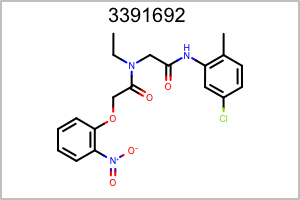
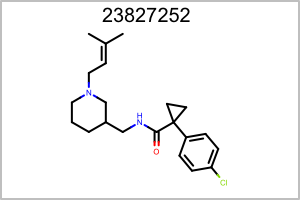
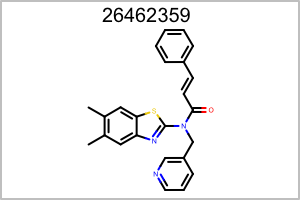
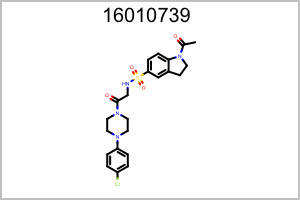
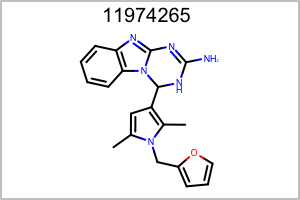

In [15]:
# I think HTML rendering of tooltips will be fixed in 0.9.3
# see https://github.com/bokeh/bokeh/issues/2728


# Store data in a bokeh object data object and add images
source = ColumnDataSource(df.drop("Molecule",axis=1))
source.add(df.Molecule.apply(lambda x: oenb.draw_mol_to_html(x,300,200)),name="img")

p = figure(title="Molecule", tools=TOOLS)
p.xaxis.axis_label = 'MW'
p.yaxis.axis_label = 'XLogP'

# Make scatterplot
p.circle("MW", "XlogP", fill_alpha=0.2, size=10, source=source)

# Create tooltips referencing stored images
tooltips = """<img src=@img>"""

# Connect tooltips to plot
p.add_tools(HoverTool(tooltips=tooltips))

# Uncomment to create a html file of the plot.
# output_file("bokeh_plot.html")

show(p)



Again, this functionality is built in to OENotebook.

Loading BokehJS ...


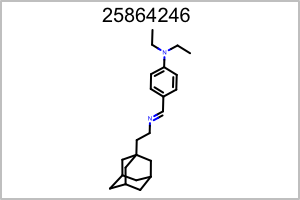
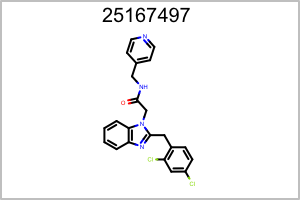
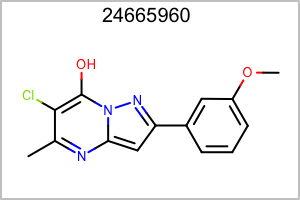
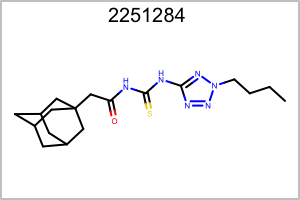
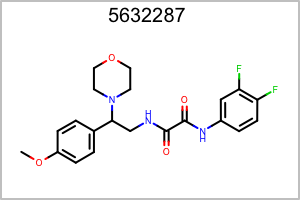
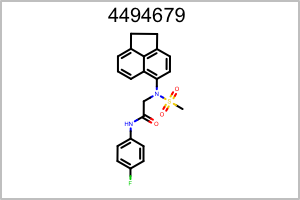
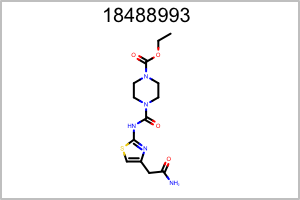
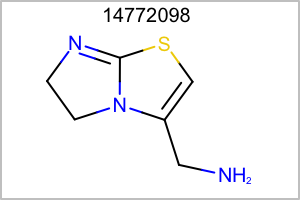
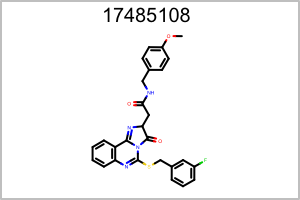
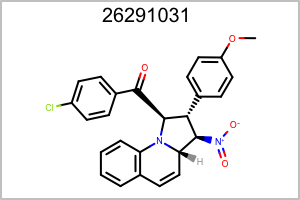
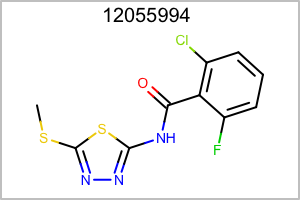
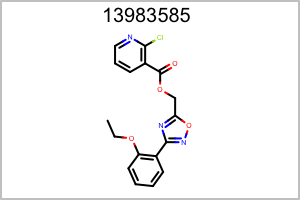
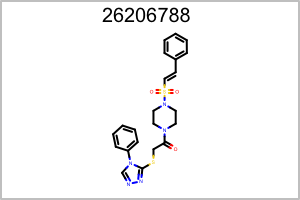
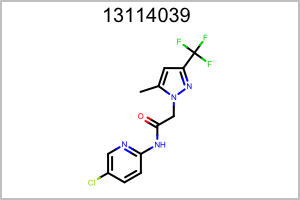
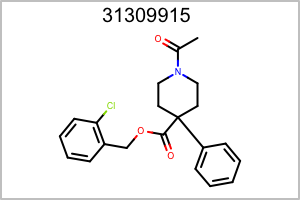
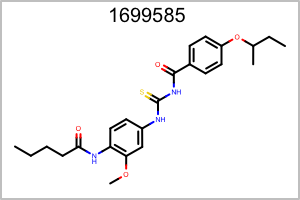
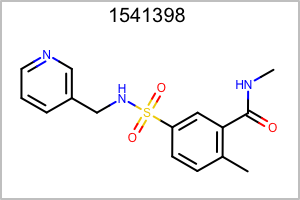
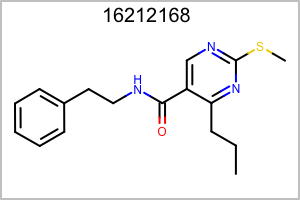
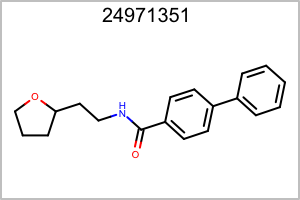
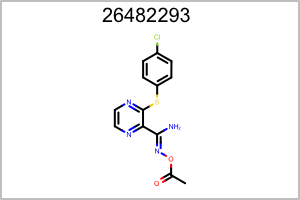
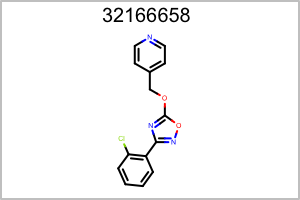
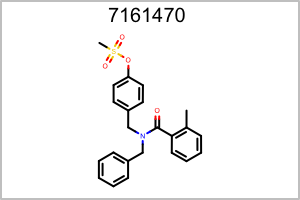
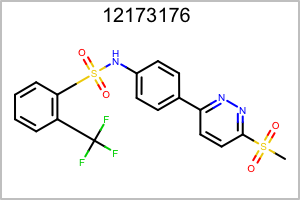
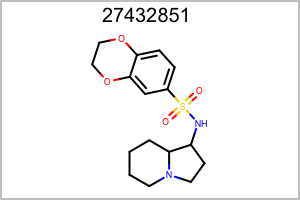
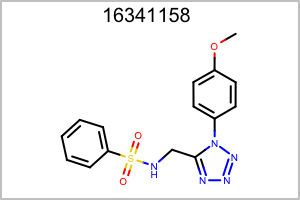
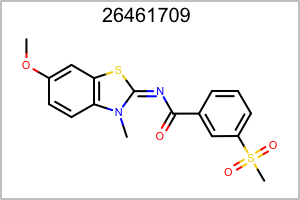
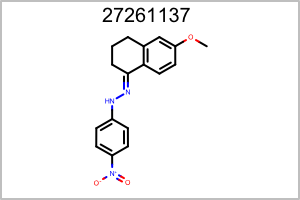
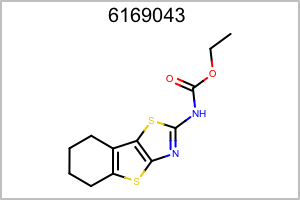
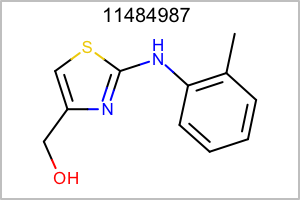
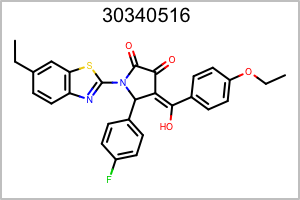
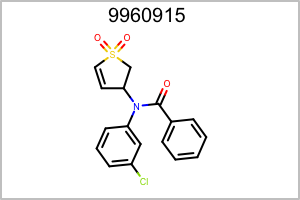
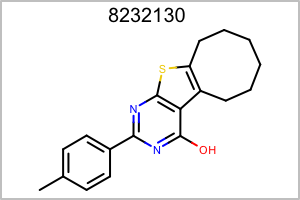
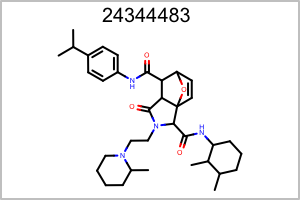
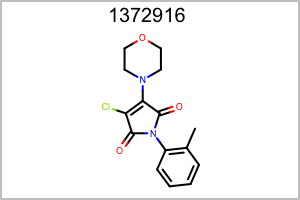
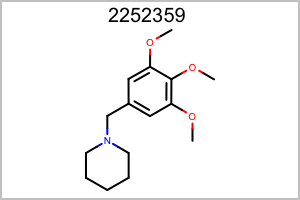
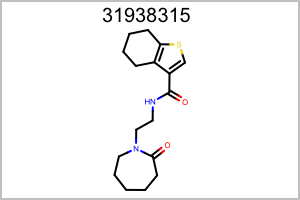
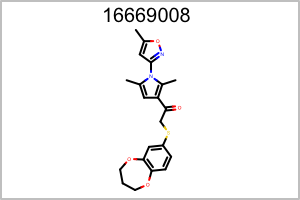
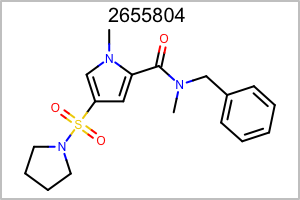
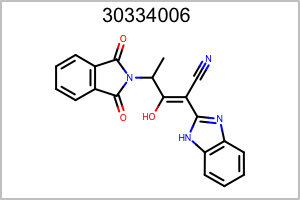
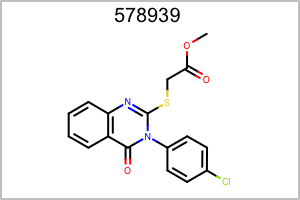
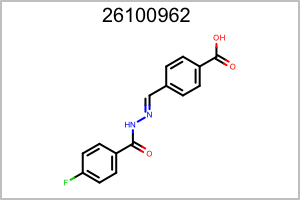
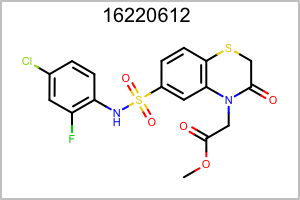
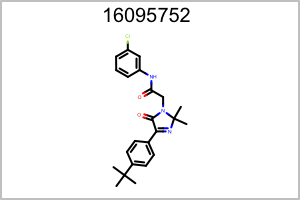
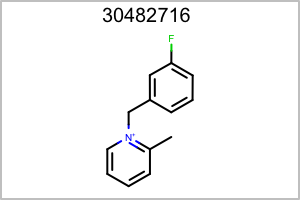
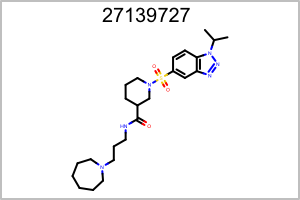
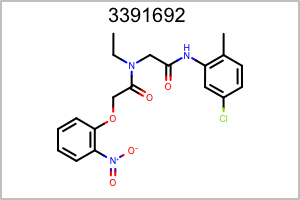
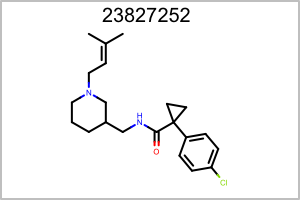
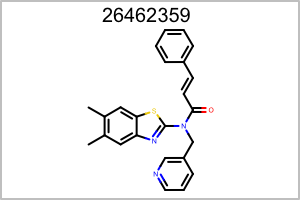
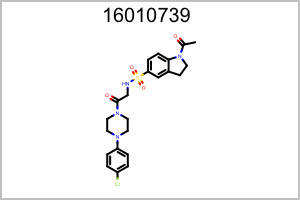
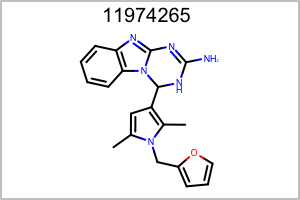
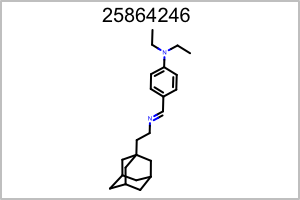
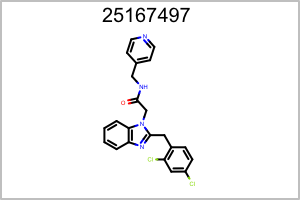
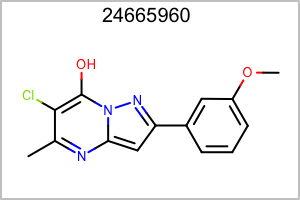
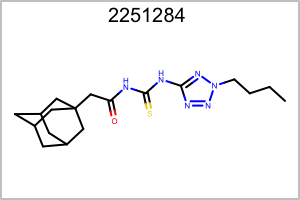
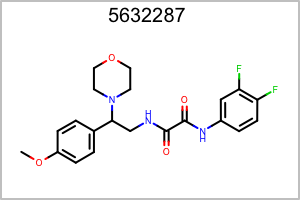
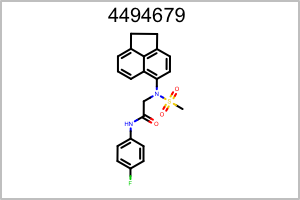
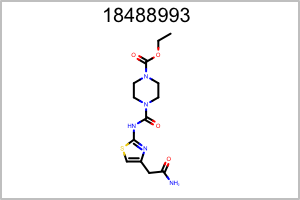
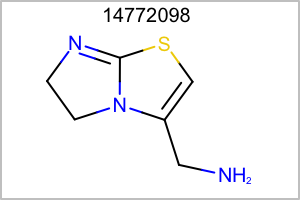
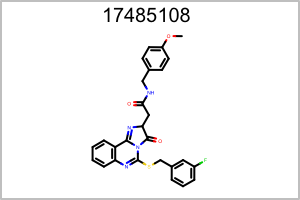
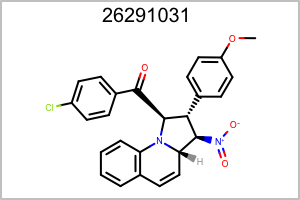
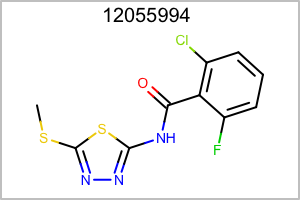
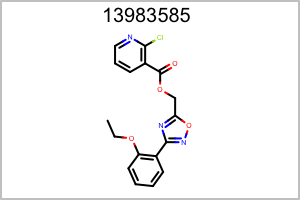
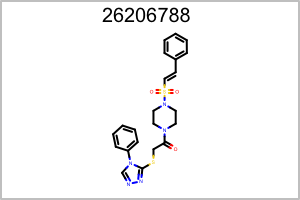
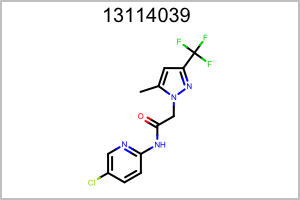
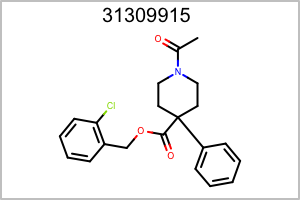
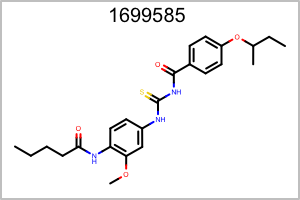
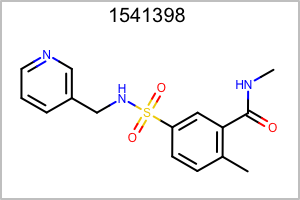
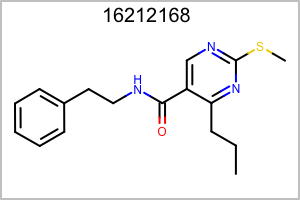
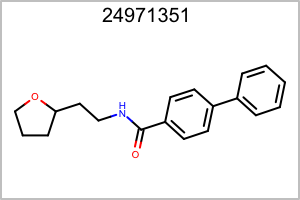
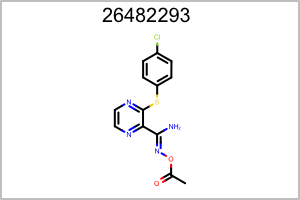
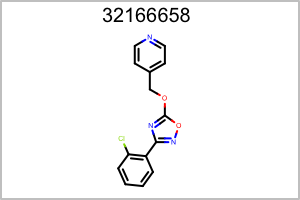
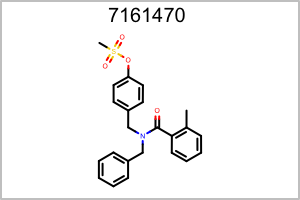
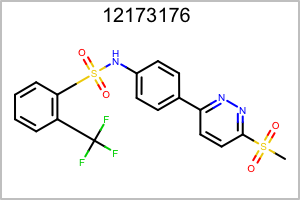
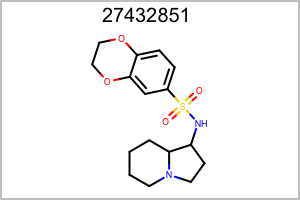
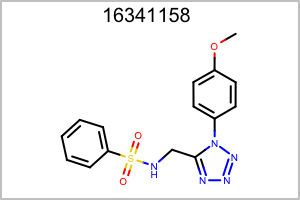
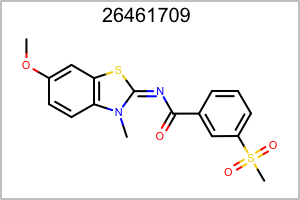
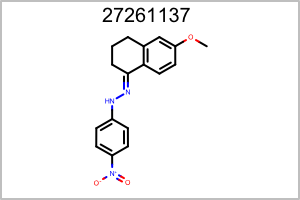
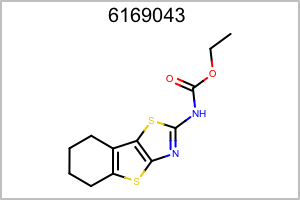
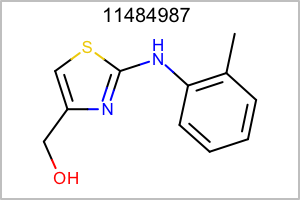
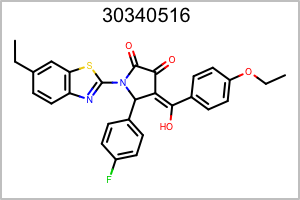
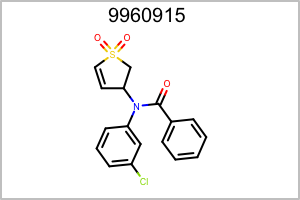
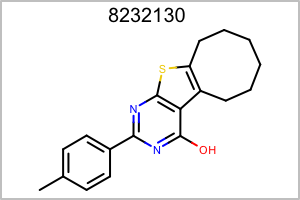
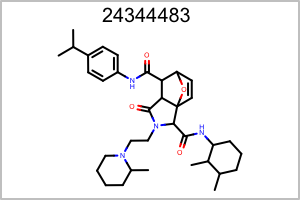
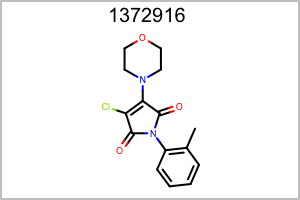
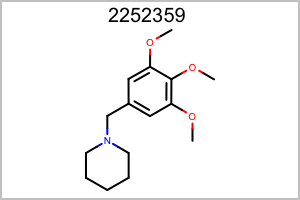
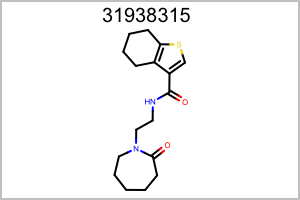
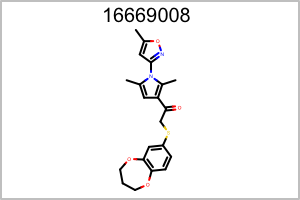
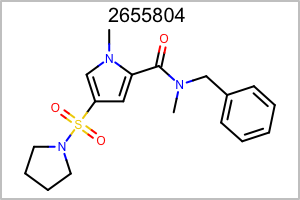
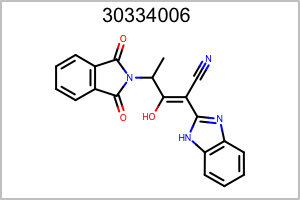
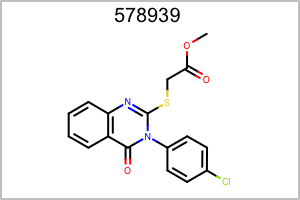
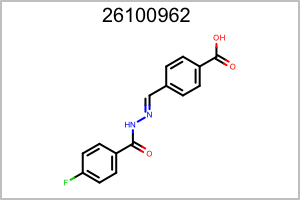
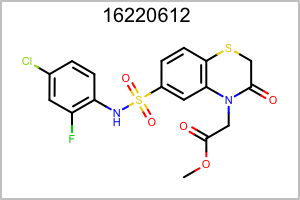
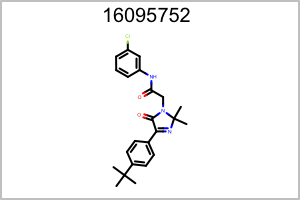
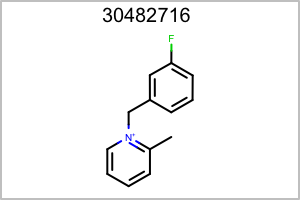
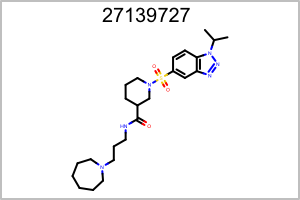
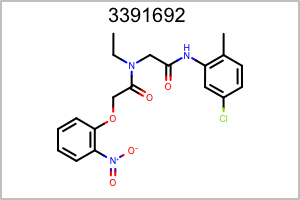
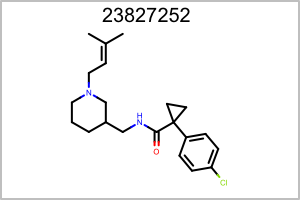
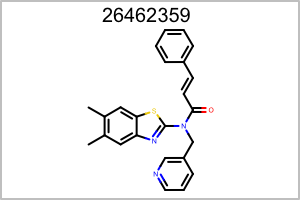
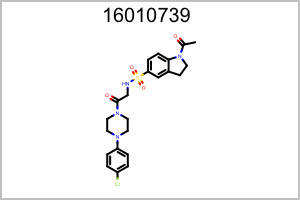
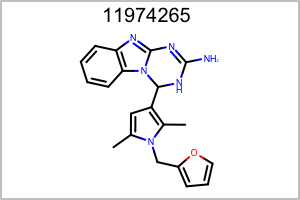

In [16]:
f = oenb.scatter_bokeh(df,"MW","XlogP")

Loading BokehJS ...


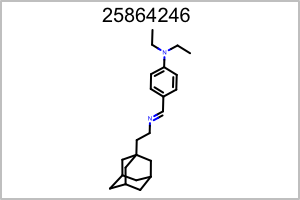
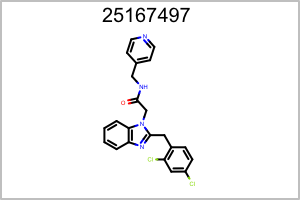
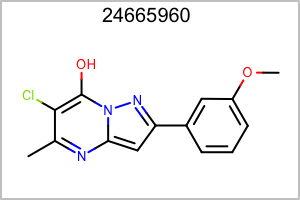
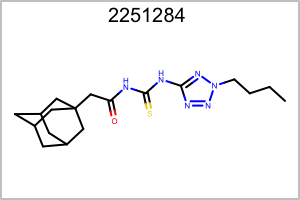
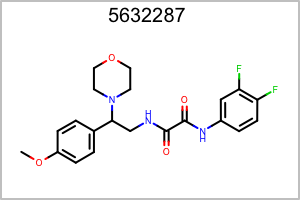
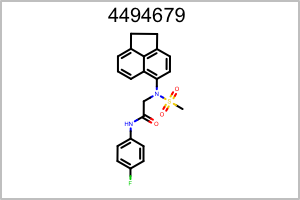
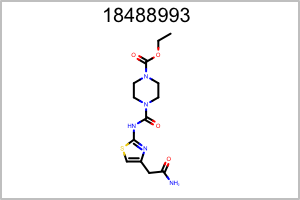
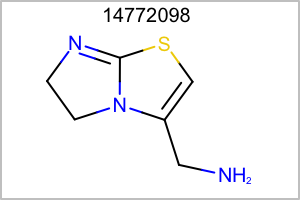
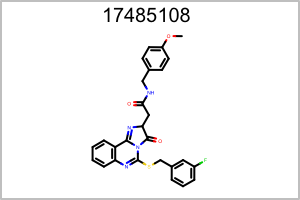
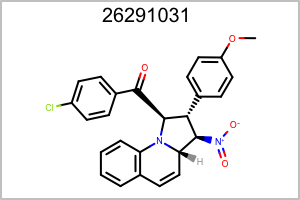
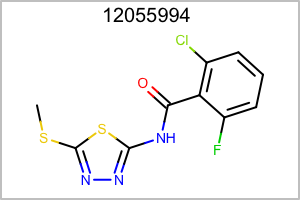
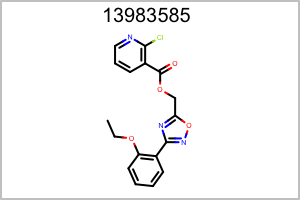
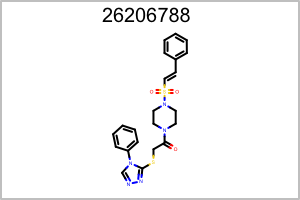
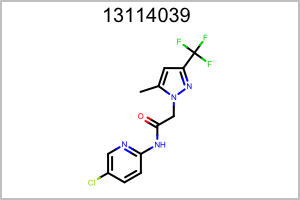
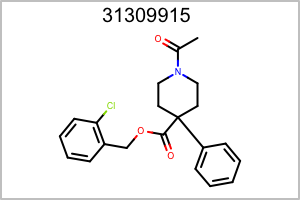
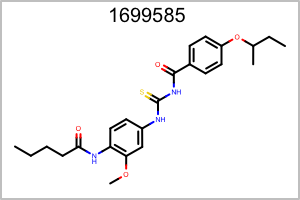
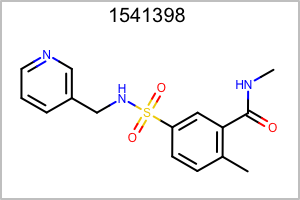
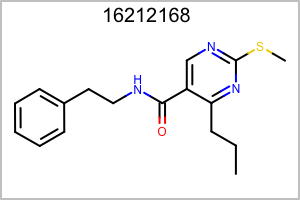
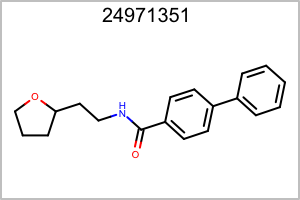
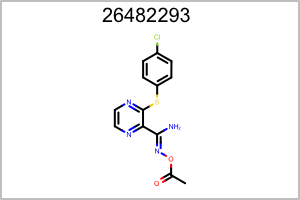
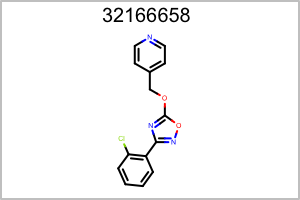
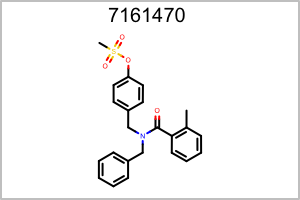
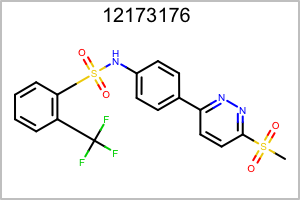
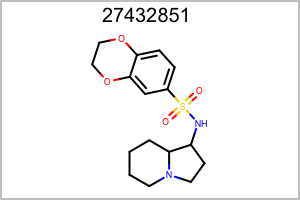
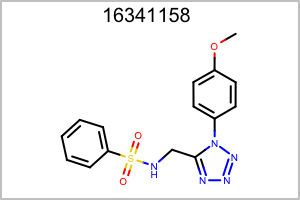
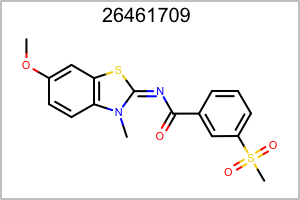
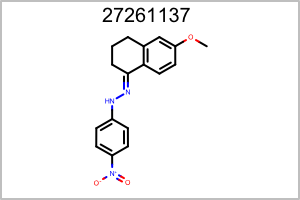
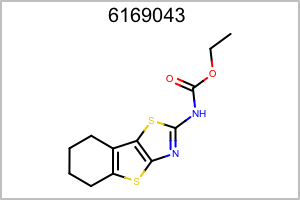
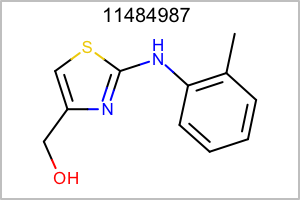
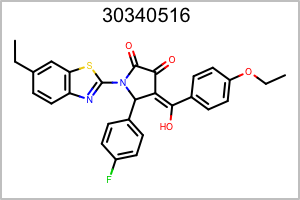
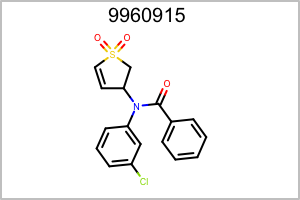
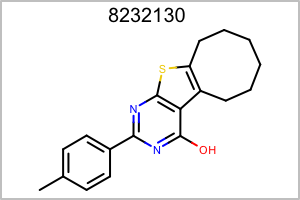
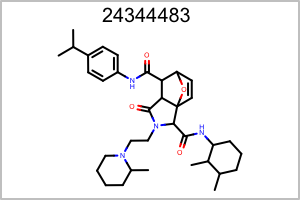
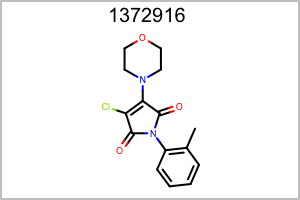
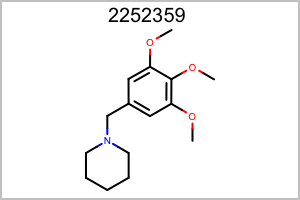
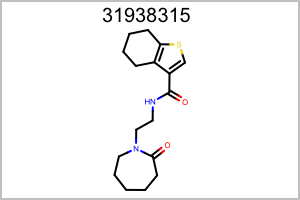
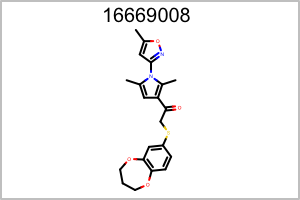
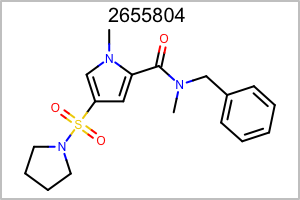
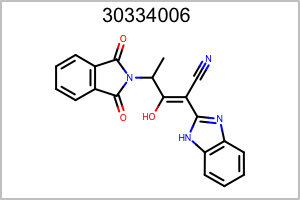
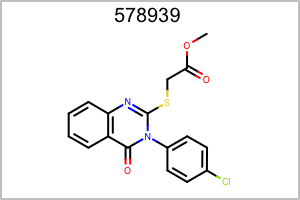
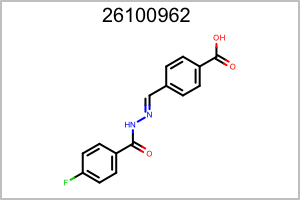
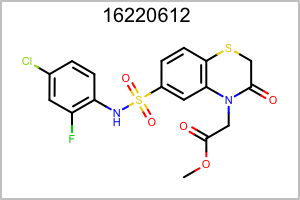
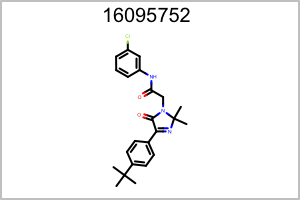
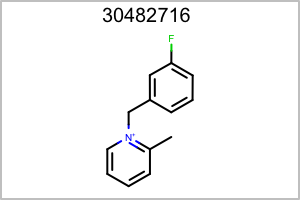
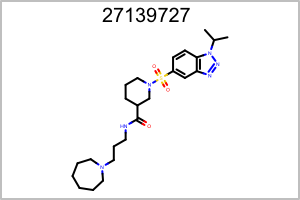
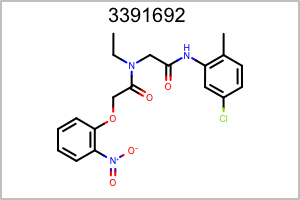
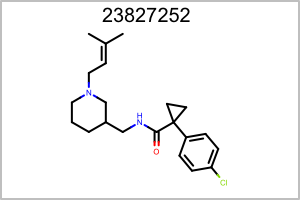
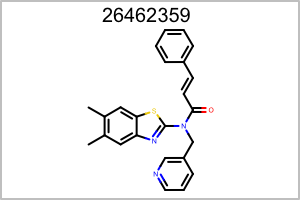
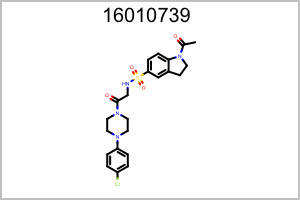
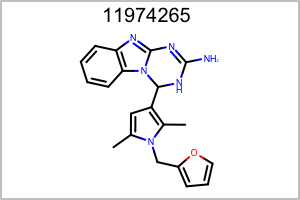
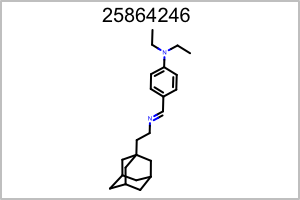
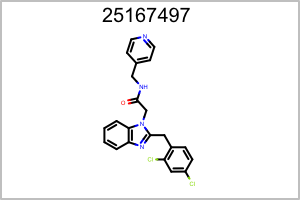
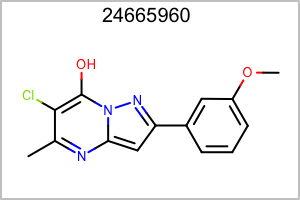
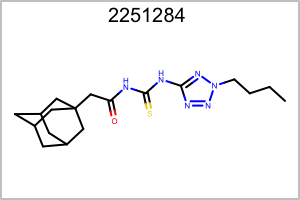
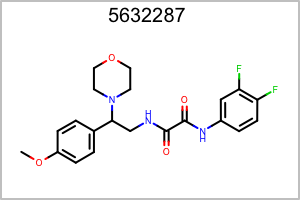
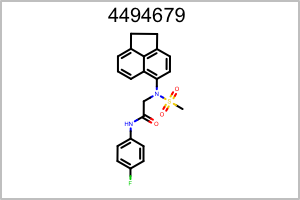
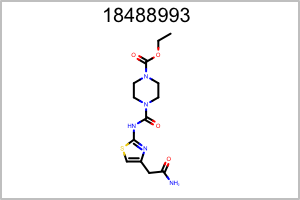
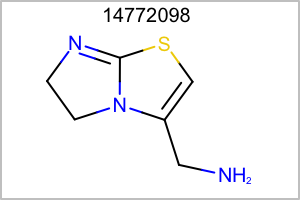
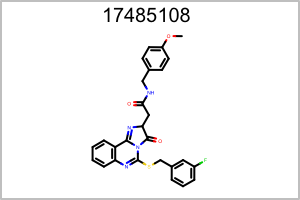
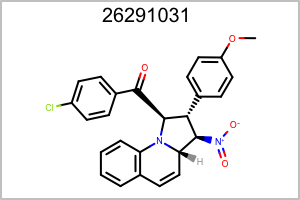
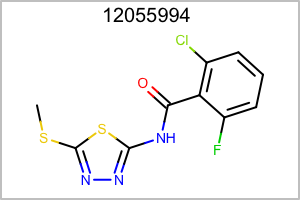
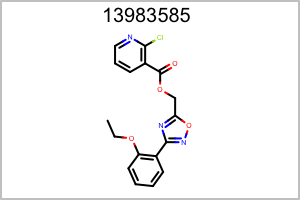
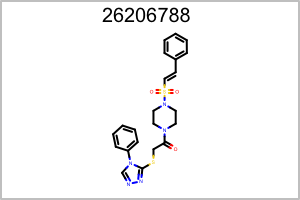
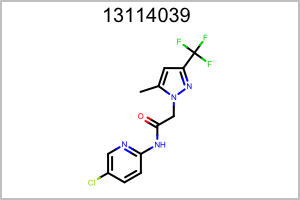
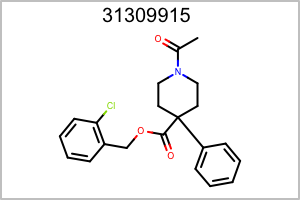
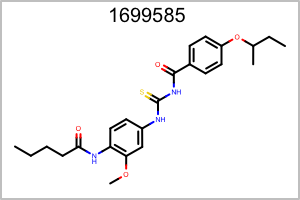
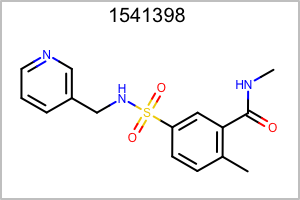
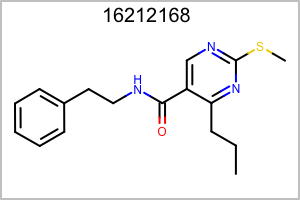
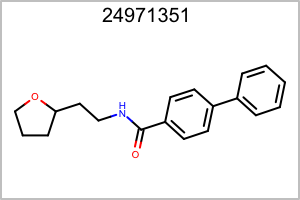
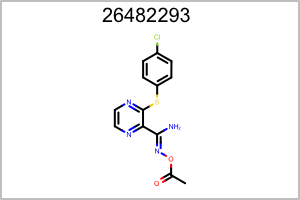
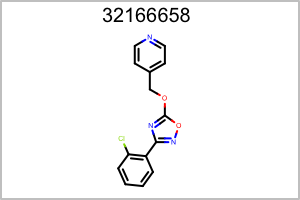
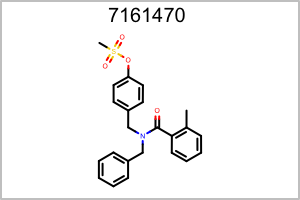
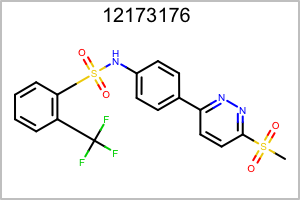
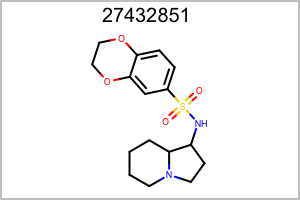
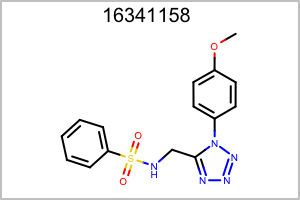
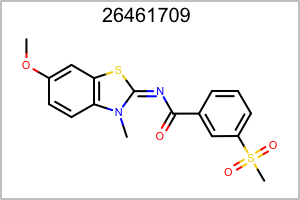
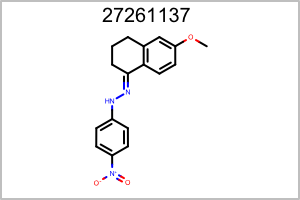
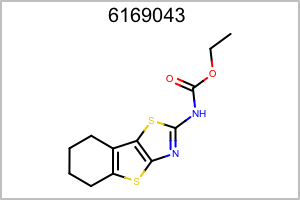
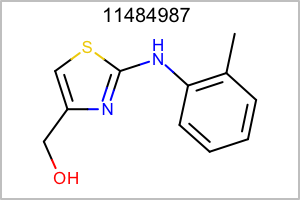
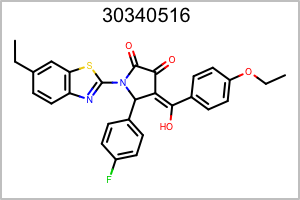
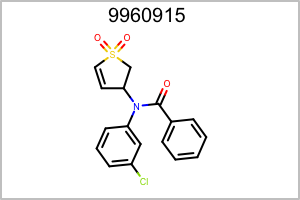
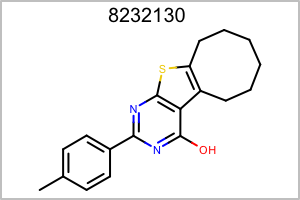
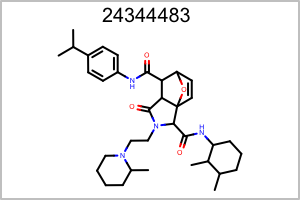
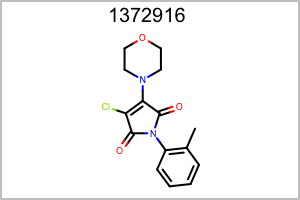
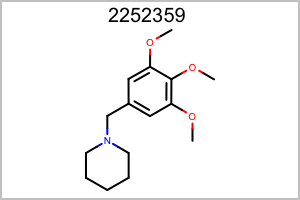
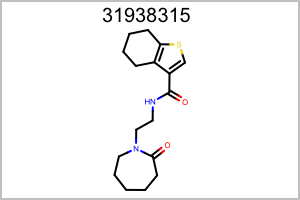
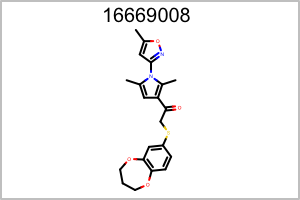
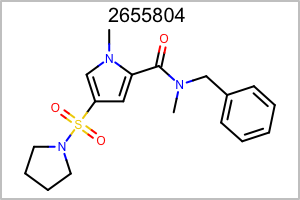
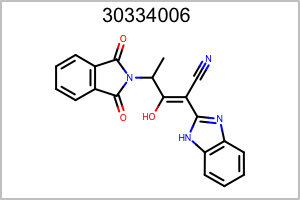
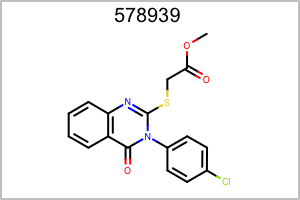
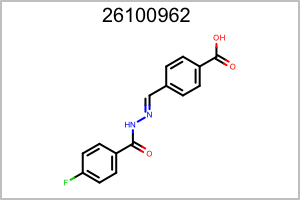
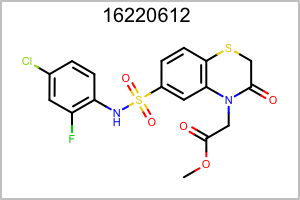
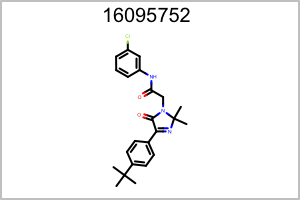
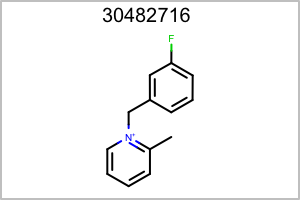
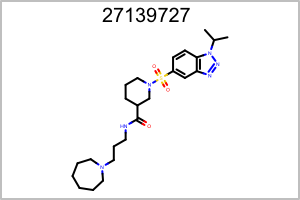
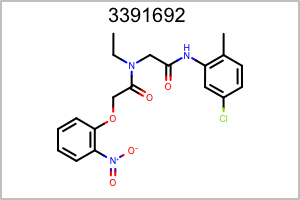
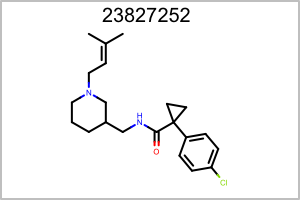
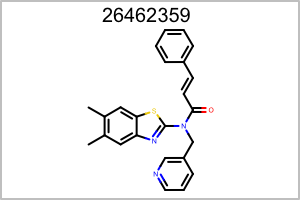
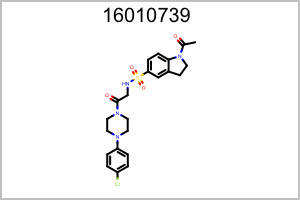
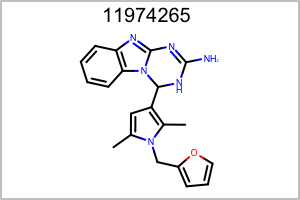
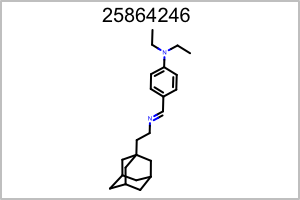
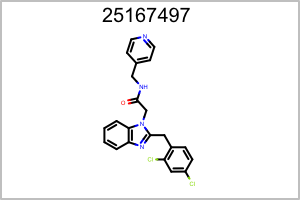
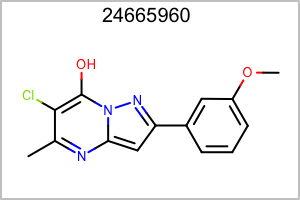
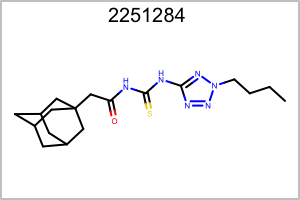
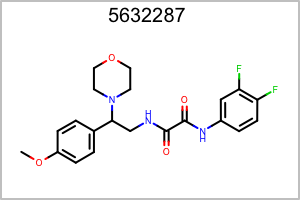
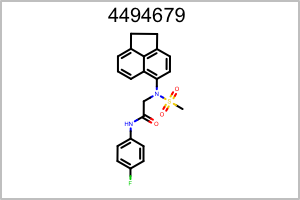
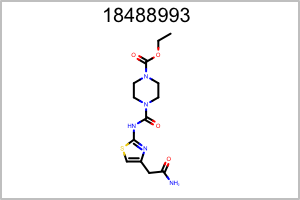
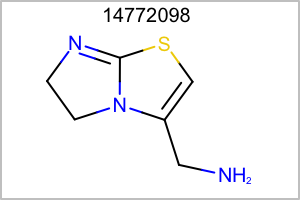
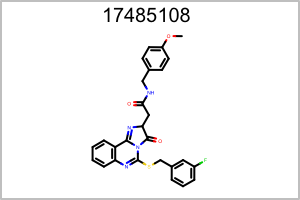
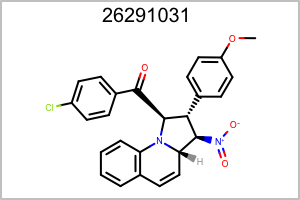
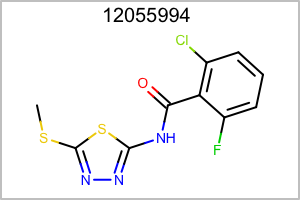
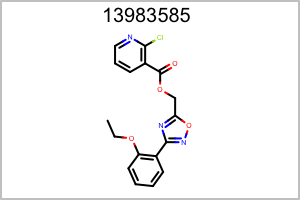
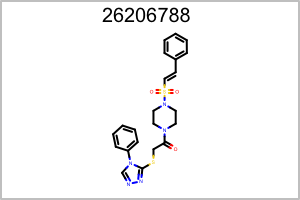
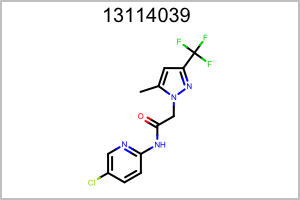
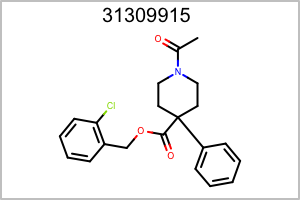
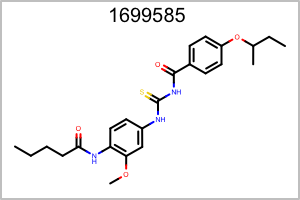
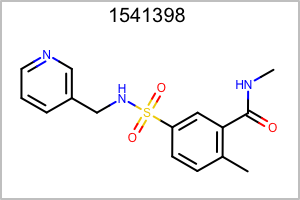
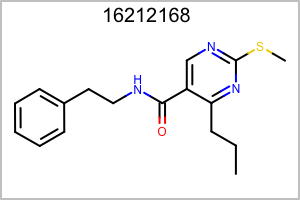
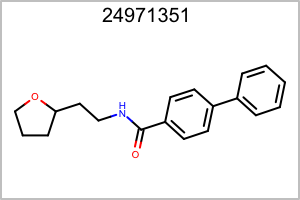
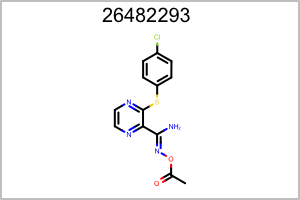
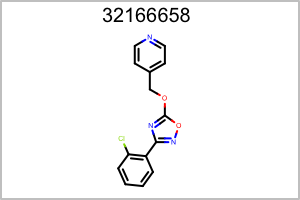
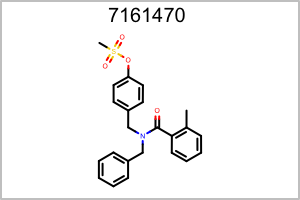
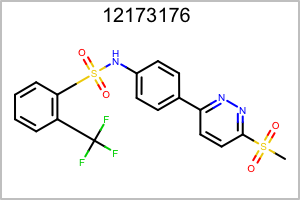
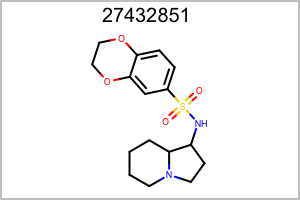
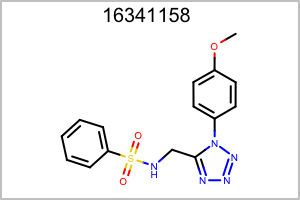
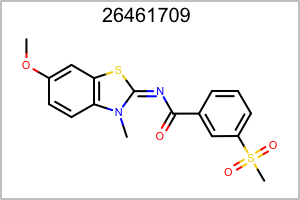
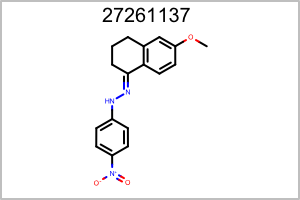
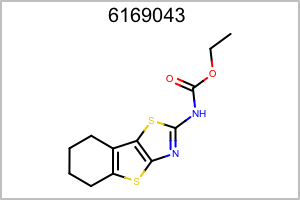
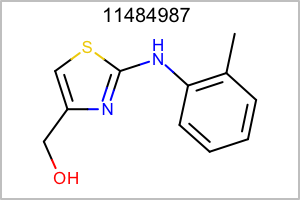
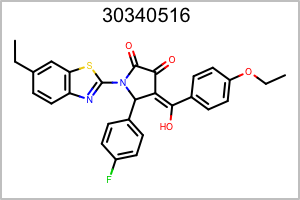
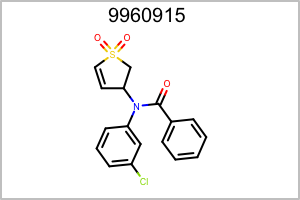
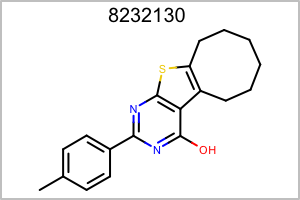
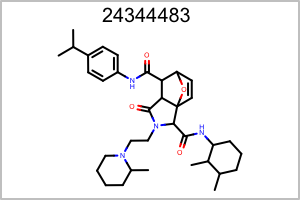
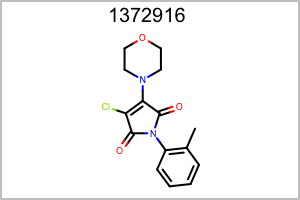
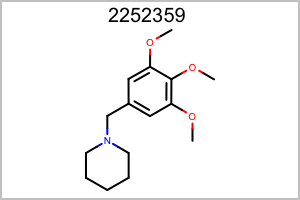
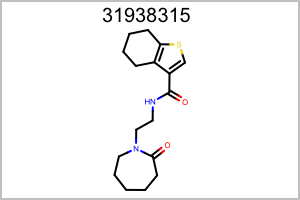
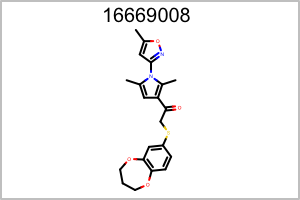
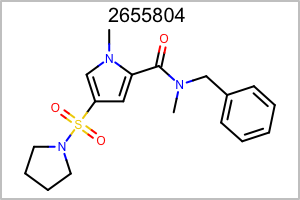
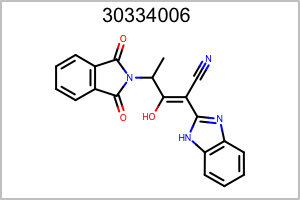
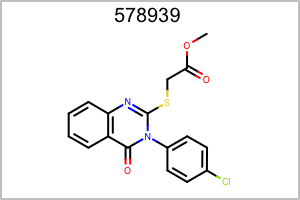
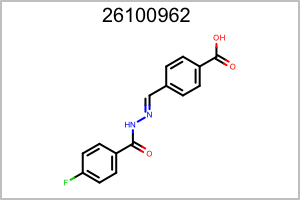
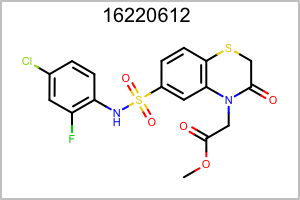
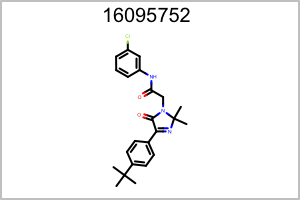
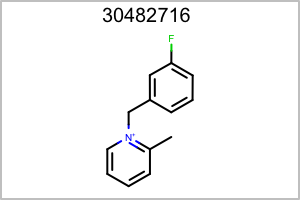
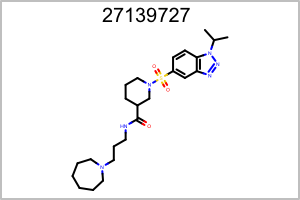
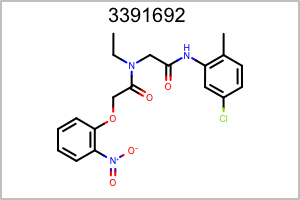
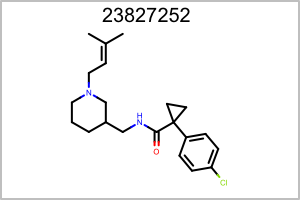
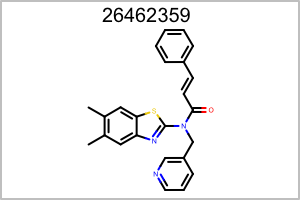
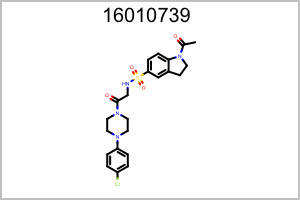
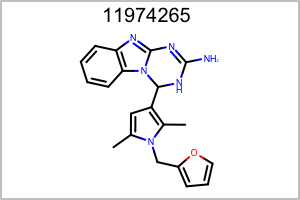

In [17]:
f = oenb.scatter_bokeh(df,"MW","XlogP",show_2D=False)

## Toyplot


[Toyplot](https://toyplot.readthedocs.org/en/latest/index.html) is a new and simple plotting toolkit.  Currently you can't make hover tooltips, but it's worth keeping an eye on it.

In [19]:
import toyplot

In [20]:
canvas = toyplot.Canvas(width=600, height=400)
axes = canvas.axes(label="Molecules", xlabel="MW", ylabel="XlogP")
mark = axes.scatterplot(df.MW,df.XlogP,size=100, opacity=0.5)

200 300 400 500 600 MW 0 2 4 6 XlogP Molecules Save as .csv

In [21]:
# Version Reporting

from openeye.oechem import OEChemGetVersion
print("OEChem: {}".format(OEChemGetVersion()))
print("OENotebook: {}".format(oenb.__version__))
print("")
import matplotlib as mpl
print("matplotlib: {}".format(mpl.__version__))
print("mpld3: {}".format(mpld3.__version__))
print("")
import bokeh
print("bokeh: {}".format(bokeh.__version__))
print("")
print("toyplot: {}".format(toyplot.__version__))


OEChem: 20160209
OENotebook: 0.8.1

matplotlib: 1.5.1
mpld3: 0.2

bokeh: 0.11.1

toyplot: 0.11.0
